<a href="https://colab.research.google.com/github/Beitner/Computer-vision---Cell-Counting/blob/main/Super_resolution_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Comuter Vision - Super Resolution

The purpose of this notebook is building a fully-convolutional network and using perceptual
loss in order to boost the performance.

We will specifically use the task of image super-resolution to enlarge image resolution by a
factor of 2.

Originally, the idea for adding perceptual loss to the regular super resolution loss was suggested
in the paper "Perceptual Losses for Real-Time Style Transfer and Super-Resolution" (Johnson
et al. 2016, http://svl.stanford.edu/assets/papers/JohnsonECCV16.pdf).
Usually this type of task takes a long time to train, because of the complex networks used for it.
In this exercise we take the ideas from this paper, but make it manageable, with a rather small
network, a small number of training images and working with small images (dimensions).

# Loading VOC 2011

In [ ]:
# import scipy.io
import numpy as np
import torch
import torch.optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.autograd import Variable
from PIL import Image
# import matplotlib.pyplot as plt
# from scipy.stats import kde
import cv2 as cv
import torch.nn.functional as F
import random
import operator
from itertools import tee
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchsummary import summary
import copy
from PIL import Image, ImageOps
from torchvision import datasets, models, transforms

from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torchvision.io import read_image
import os
import pandas as pd
from torch.utils.data import Dataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

import copy
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import sklearn
%matplotlib inline
import torch
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, Dataset
import torchvision
import torchvision.models as models
import os
import time
import copy
from PIL import Image, ImageOps
from torchvision import datasets, models, transforms


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# VOC = datasets.VOCSegmentation(root='./data', year = '2011', image_set = 'val', download = True)
PATH = r'/content/drive/MyDrive/Colab Notebooks/VOC2011/JPEGImages'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

For the training, we need pairs of images: low-resolution and its high-resolution version. In this
exercise we will apply super resolution from 120x120x3 to 240x240x3.

Create dataloaders

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform_high=None,transform_low=None):
        self.img_dir = img_dir
        self.transform_high = transform_high
        self.transform_low = transform_low
        self.img_fnames = os.listdir(self.img_dir)
    def __len__(self):
        return len(self.img_fnames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_fnames[idx])
        image = read_image(img_path)
        if self.transform_high:
            image_high = self.transform_high(image)
        if self.transform_low:
            image_low = self.transform_low(image)
        return image_high, image_low

In [ ]:
data_transforms = {
    'HIGH': transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Resize((240,240)),


    ]),
    'LOW': transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Resize((120,120)),
        transforms.Resize((240,240)),

    ]),
}

ds = CustomImageDataset(PATH,transform_high=data_transforms['LOW'],transform_low=data_transforms['HIGH'])

Let's load the low and high resolution photos:

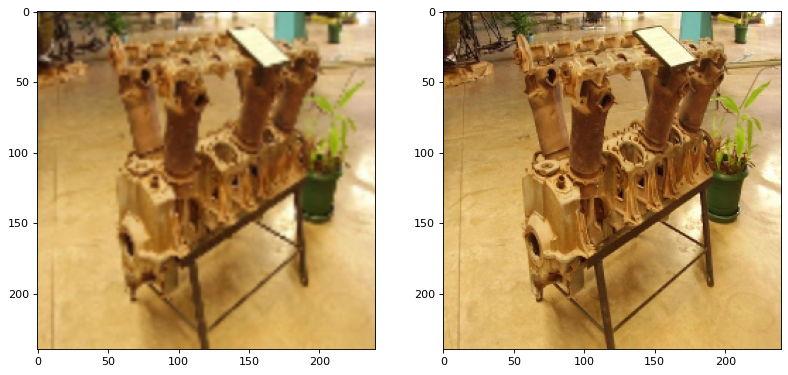

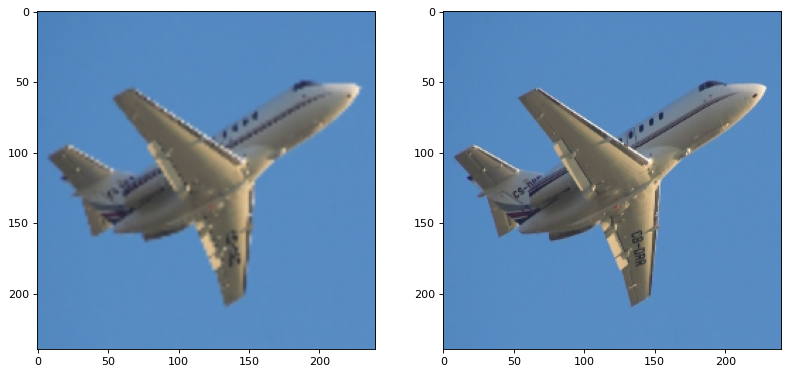

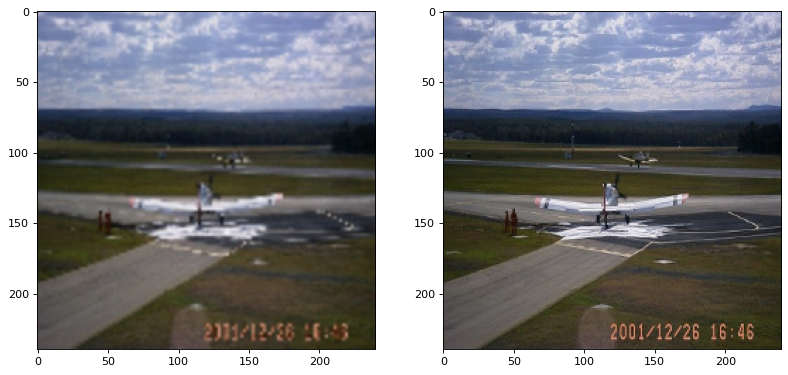

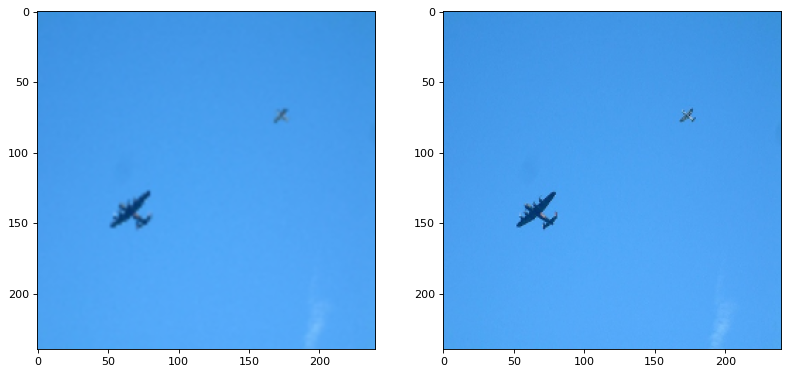

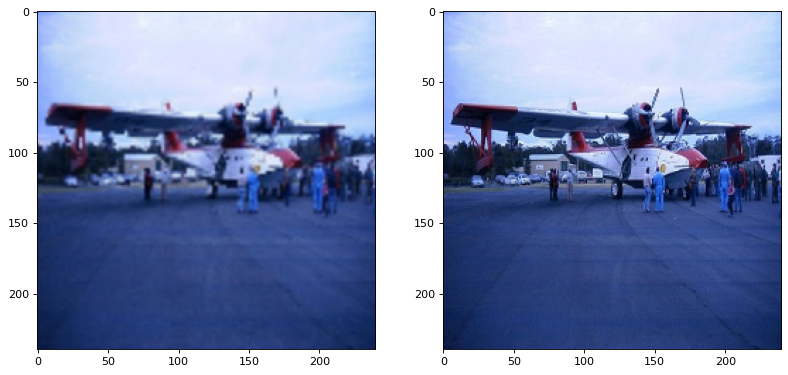

In [ ]:
for i in range(5):
  resize  = (ds[i][0])
  lable = (ds[i][1])
  fig = plt.figure(figsize=(12,12),dpi=80)
  ax = fig.add_subplot(1, 2, 1)
  ax.imshow(np.transpose(resize,(1, 2, 0)))
  ax2 = fig.add_subplot(1, 2, 2)
  ax2.imshow(np.transpose(lable,(1, 2, 0)))

This results in a blurry 240x240x3 image that does not have the details as the ground truth has.
We can say that the purpose of the network is to de-blur the input image and add the details the
blurry image doesn't have.

In [ ]:
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(ds, [train_size, test_size])

In [ ]:
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=8,
                                             shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                          shuffle=False, num_workers=4),

  }

image_datasets =dict()
image_datasets['train']=train_dataset
image_datasets['val']=test_dataset

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print('dataset_sizes: ', dataset_sizes)

dataset_sizes:  {'train': 800, 'val': 200}


# Creating the model SRCNN

In [ ]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4, padding_mode='replicate') 
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0, padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2, padding_mode='replicate')
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Training the model using optimizer and MSE-loss

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_list = [] #For printing the plot of the loss and accuracy
    train_acc_list = []

    val_loss_list = []
    val_acc_list = []
    results=[]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            

            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    if (phase == 'val') and (epoch==num_epochs-1):
                      results.append(outputs)
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)
                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                # running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = 5 / dataset_sizes[phase]

            if phase == 'train':
              train_loss_list.append(epoch_loss)
              train_acc_list.append(epoch_acc)
            else:
              val_loss_list.append(epoch_loss)
              val_acc_list.append(epoch_acc)


            # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            print(f'{phase} Loss: {epoch_loss:.4f} ')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    


    time_elapsed = time.time() - since
    # print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    # print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    
    return model,results, train_loss_list, val_loss_list, train_acc_list, val_acc_list

In [ ]:
model=SRCNN().to(device)

# criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.003)
	# defining the loss function
criterion = torch.nn.MSELoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
print(summary(model, (3, 240, 240)))
num_epochs = 10

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 240]          15,616
            Conv2d-2         [-1, 32, 240, 240]           2,080
            Conv2d-3          [-1, 3, 240, 240]           2,403
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.66
Forward/backward pass size (MB): 43.51
Params size (MB): 0.08
Estimated Total Size (MB): 44.24
----------------------------------------------------------------
None


In [ ]:
trained_model,results1, train_loss, val_loss, train_acc, val_acc = train_model(model, 
                    dataloaders,
                       criterion, 
                       optimizer, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.0156 
val Loss: 0.0067 

Epoch 1/9
----------
train Loss: 0.0055 
val Loss: 0.0050 

Epoch 2/9
----------
train Loss: 0.0046 
val Loss: 0.0044 

Epoch 3/9
----------
train Loss: 0.0044 
val Loss: 0.0048 

Epoch 4/9
----------
train Loss: 0.0042 
val Loss: 0.0041 

Epoch 5/9
----------
train Loss: 0.0041 
val Loss: 0.0040 

Epoch 6/9
----------
train Loss: 0.0043 
val Loss: 0.0040 

Epoch 7/9
----------
train Loss: 0.0039 
val Loss: 0.0039 

Epoch 8/9
----------
train Loss: 0.0039 
val Loss: 0.0039 

Epoch 9/9
----------
train Loss: 0.0039 
val Loss: 0.0039 



Text(0, 0.5, 'Loss')

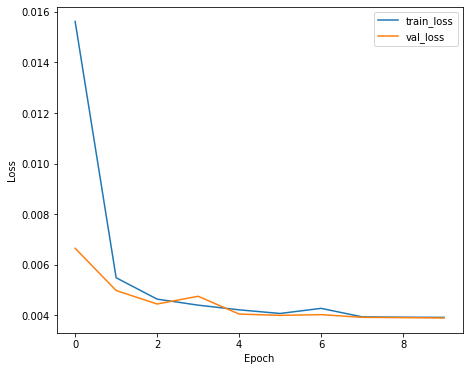

In [ ]:
fig = plt.figure(figsize = (16,6))

plt.subplot(1,2,2)
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train_loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
los_mse=results1[6]
los_mse_squeeze=torch.squeeze(los_mse, 0)
los_mse_squeeze.shape

torch.Size([3, 240, 240])

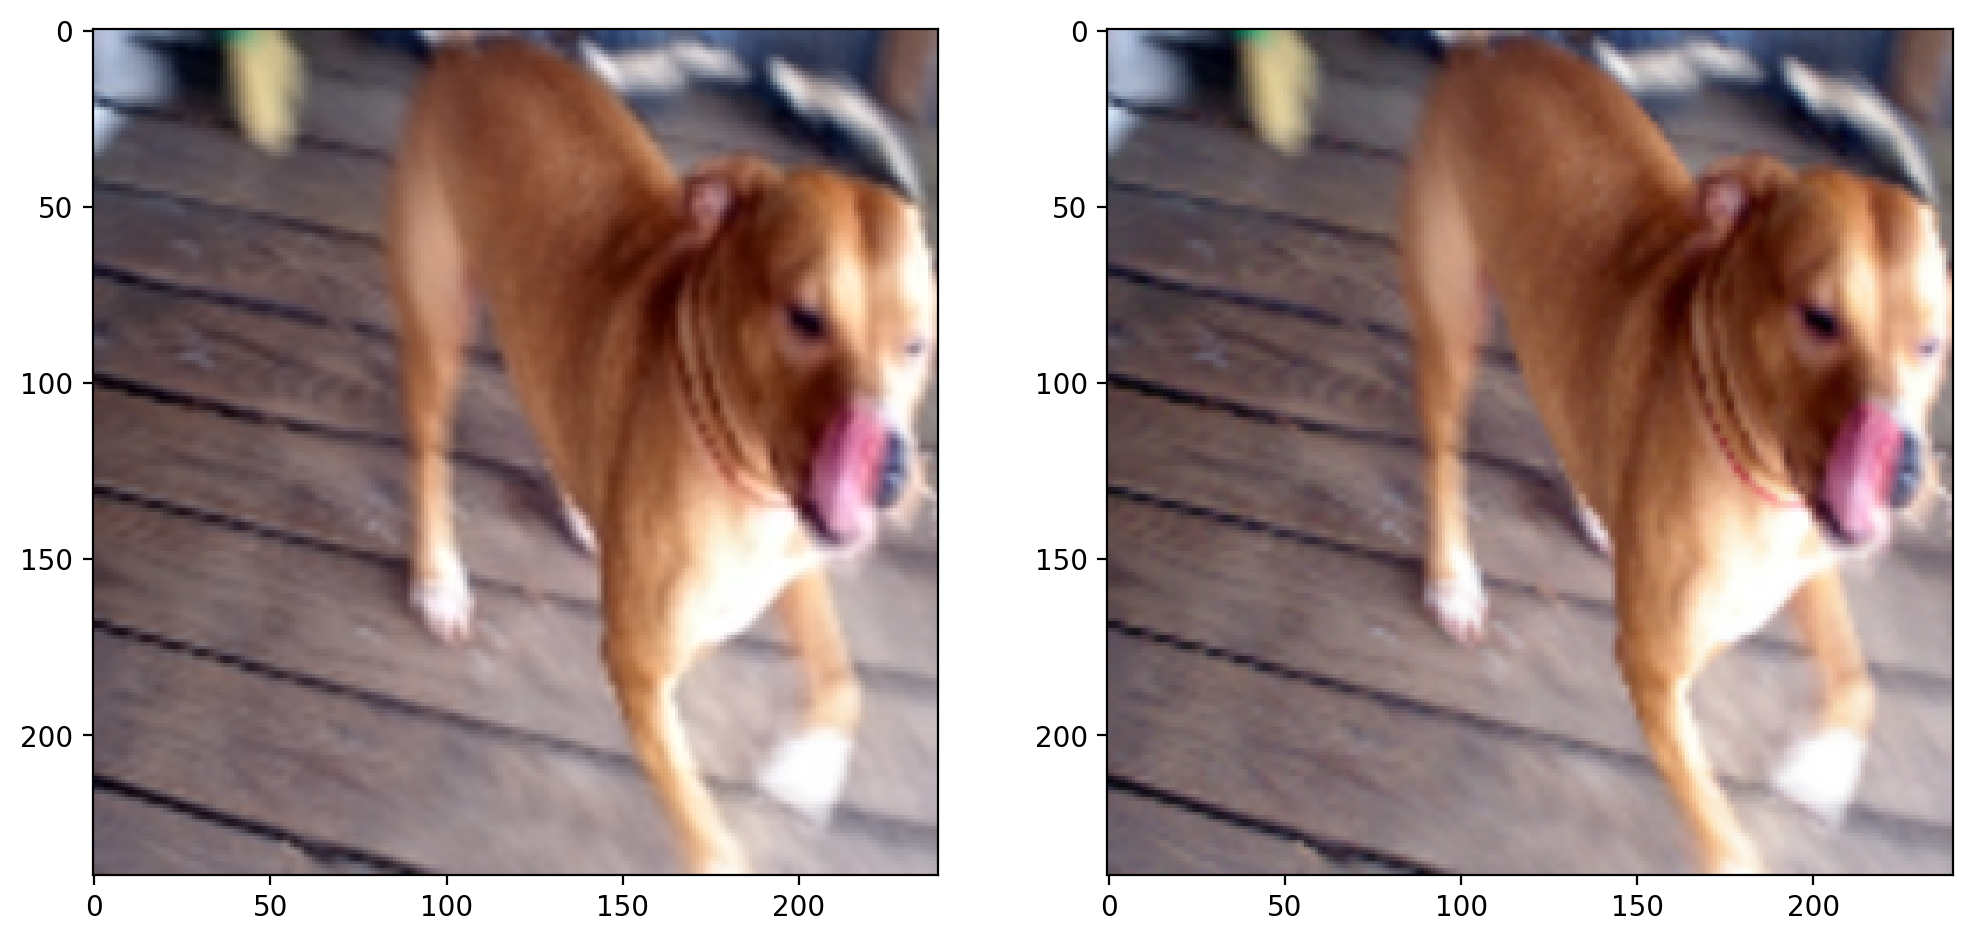

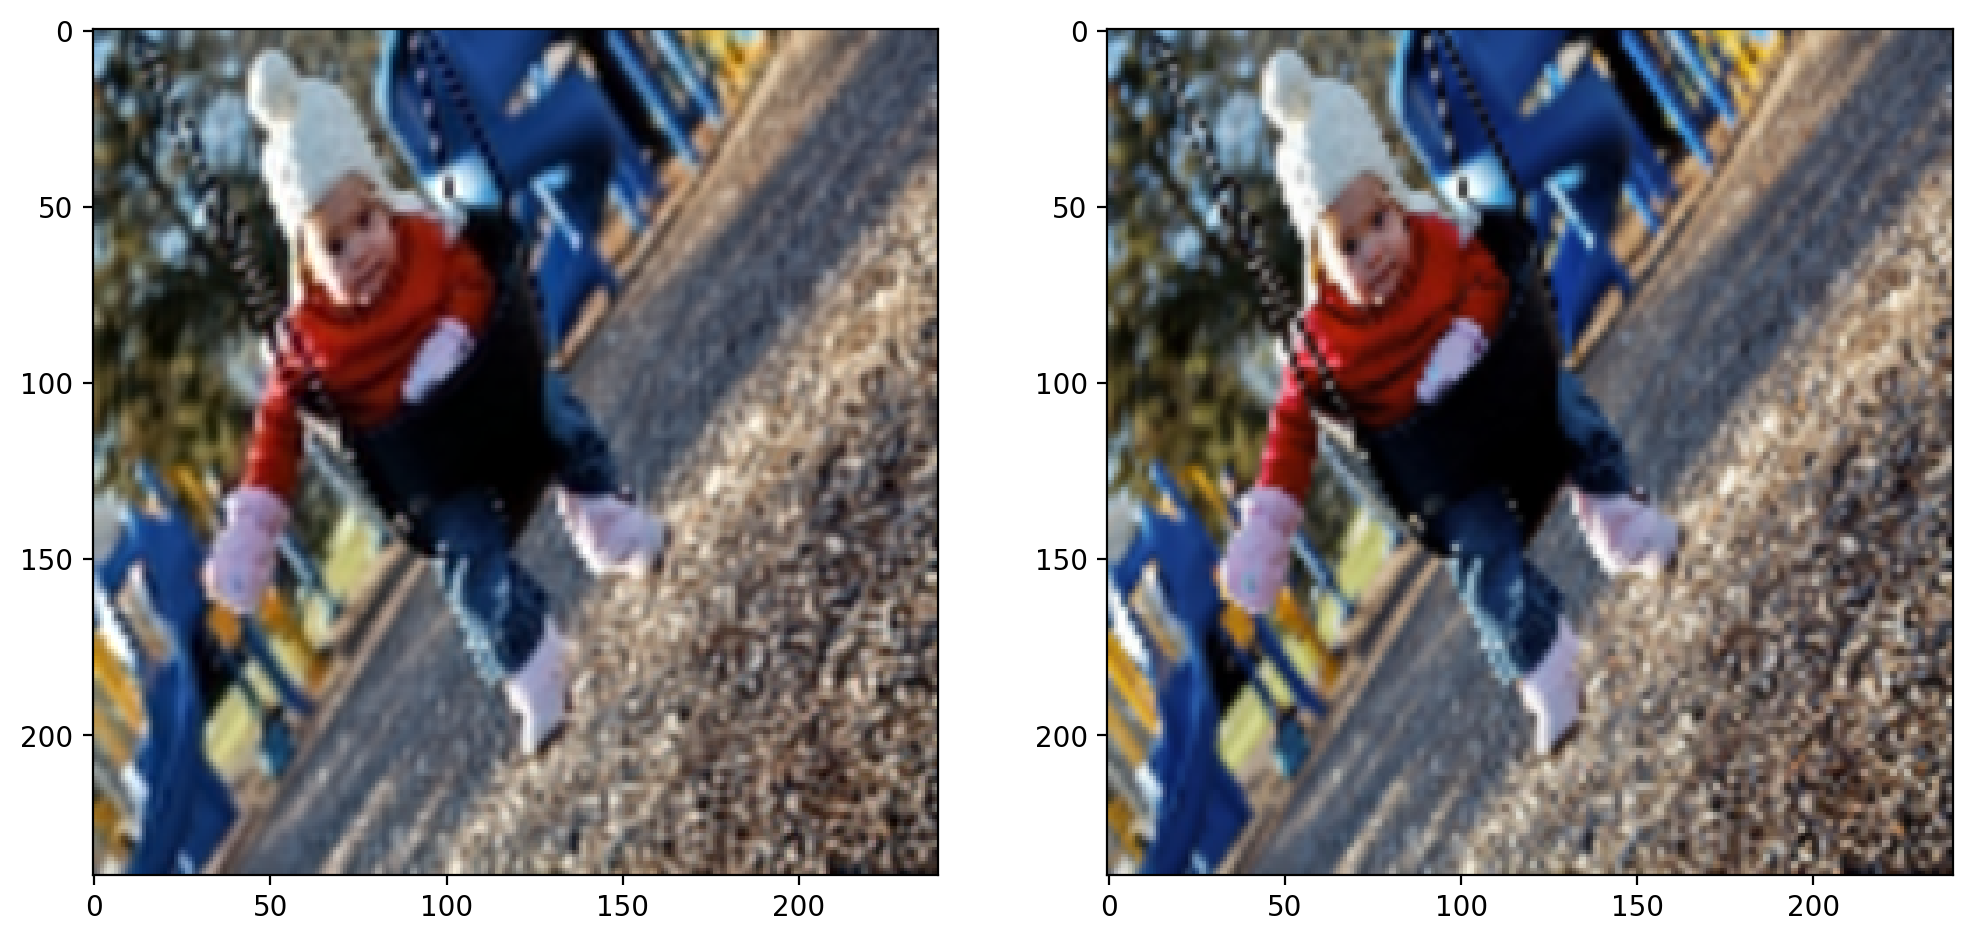

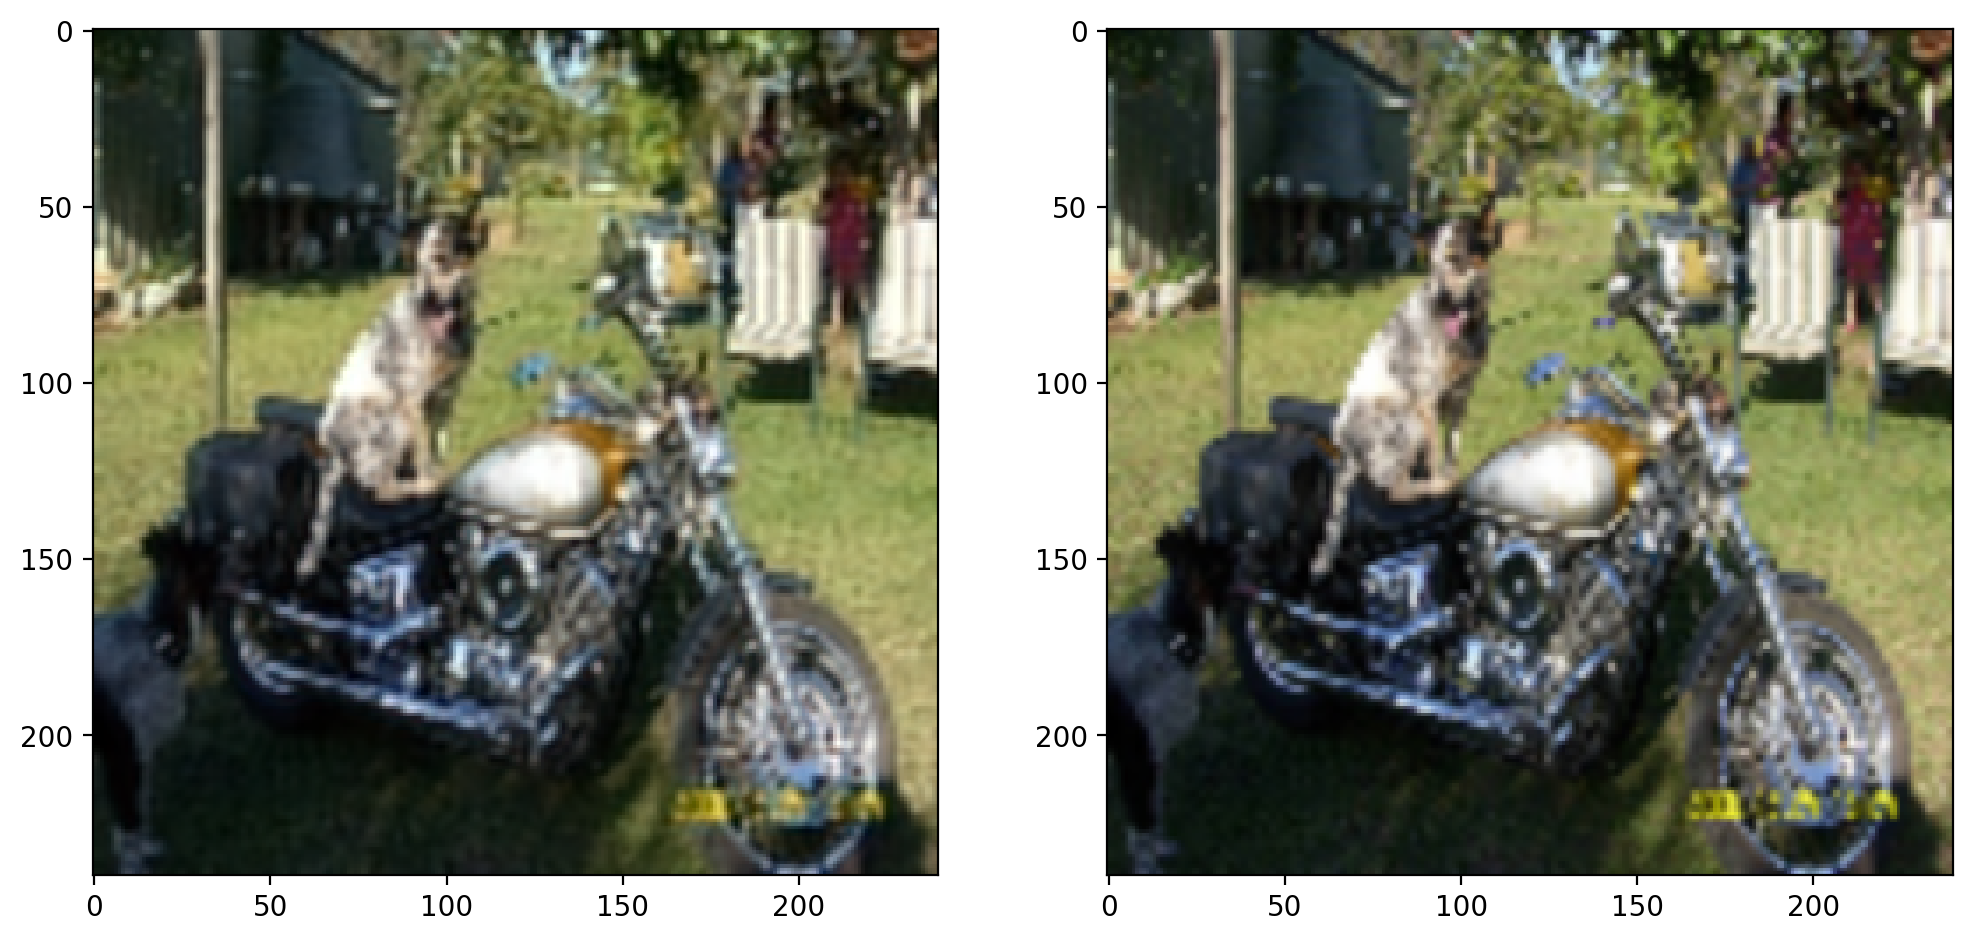

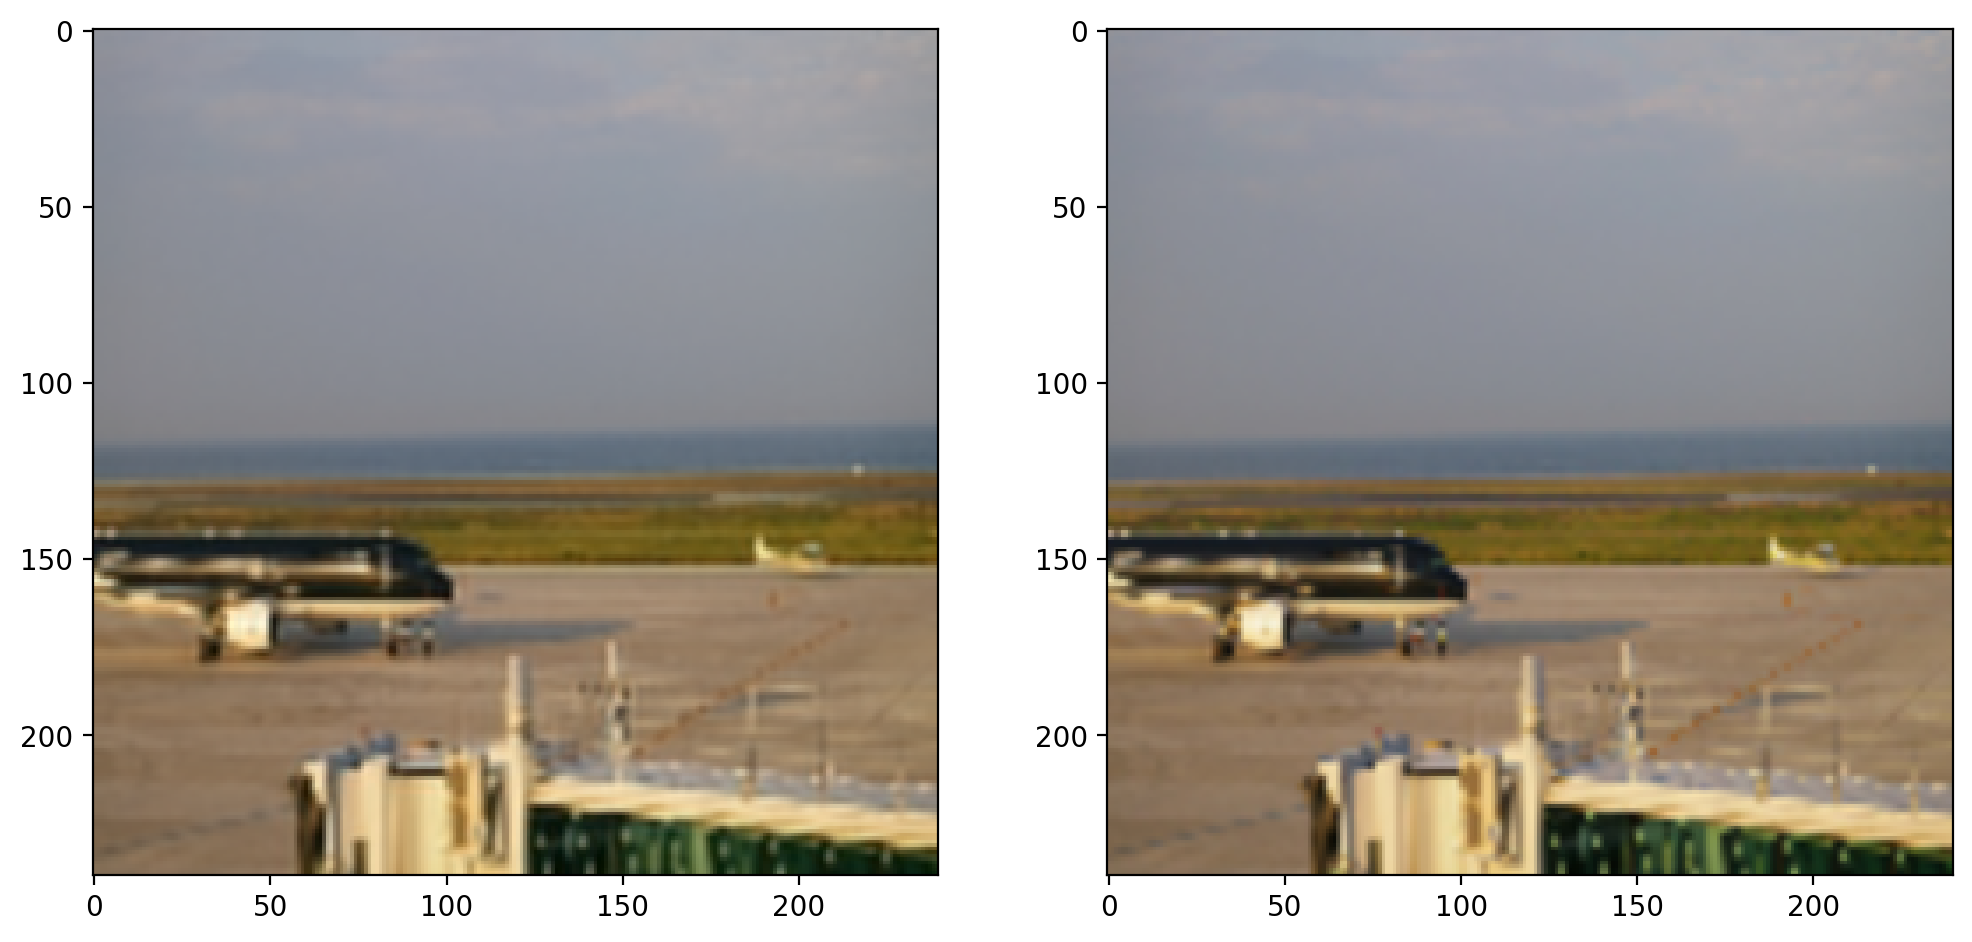

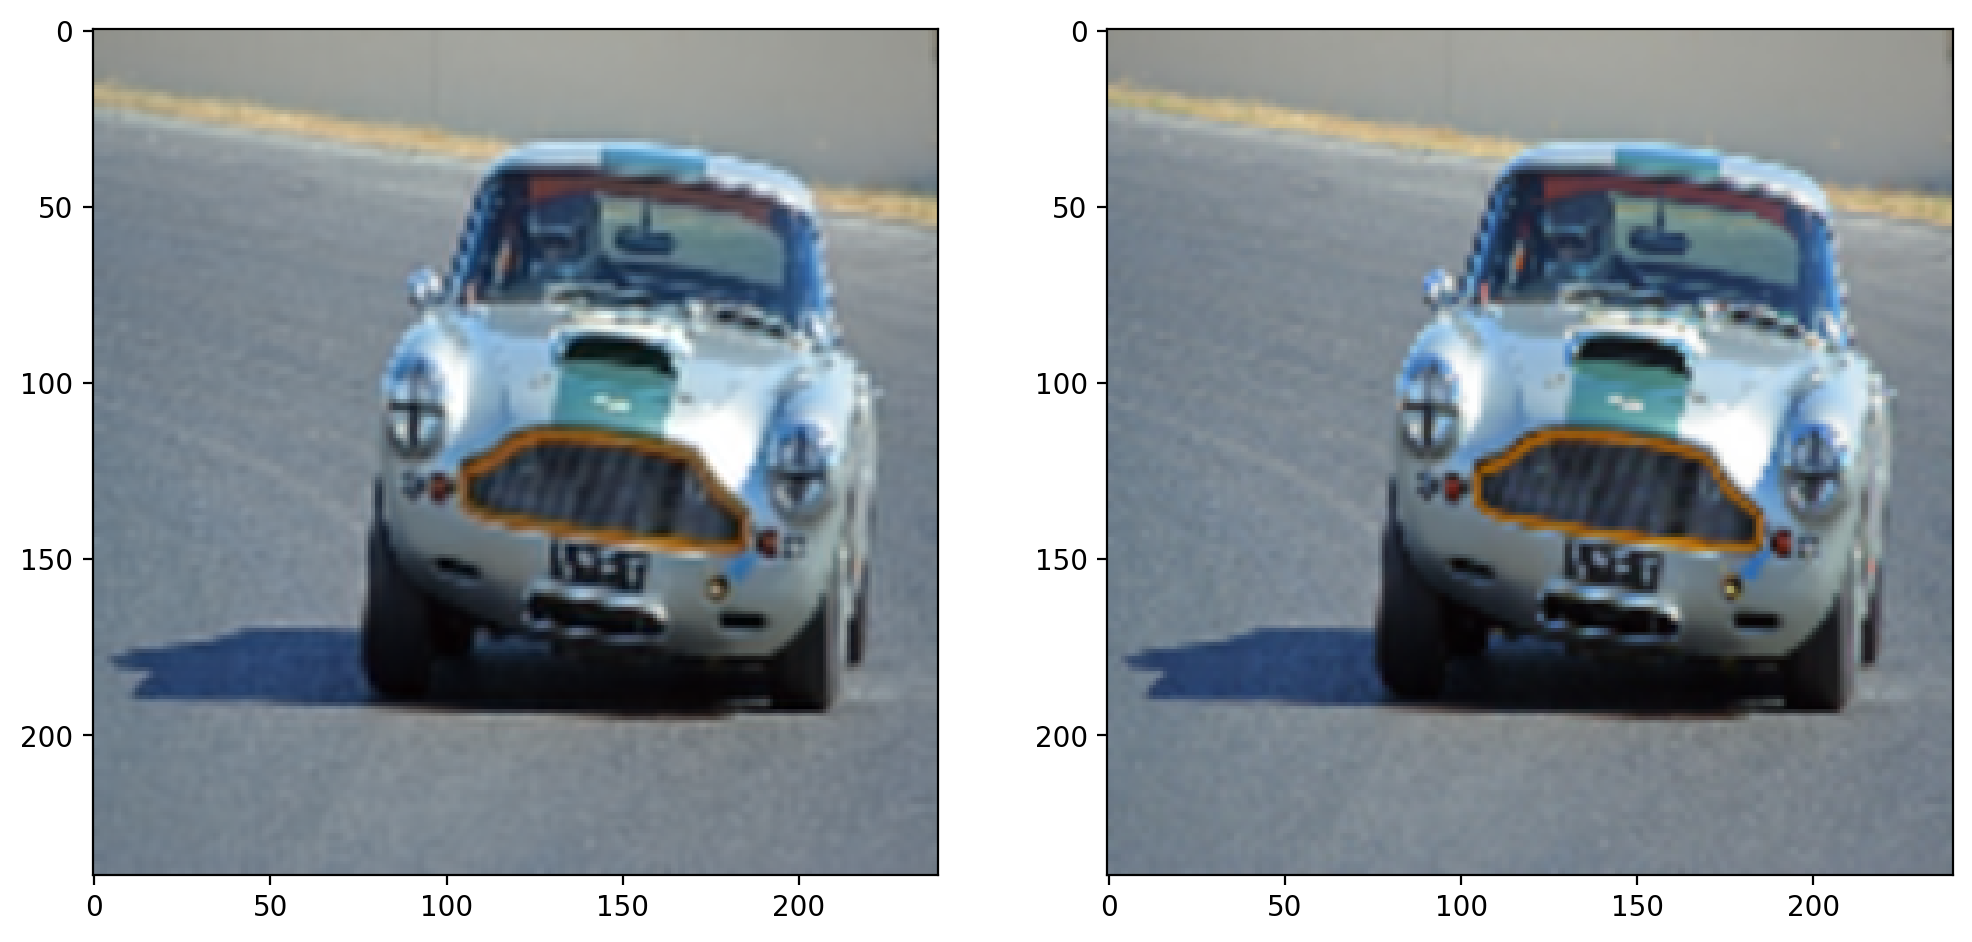

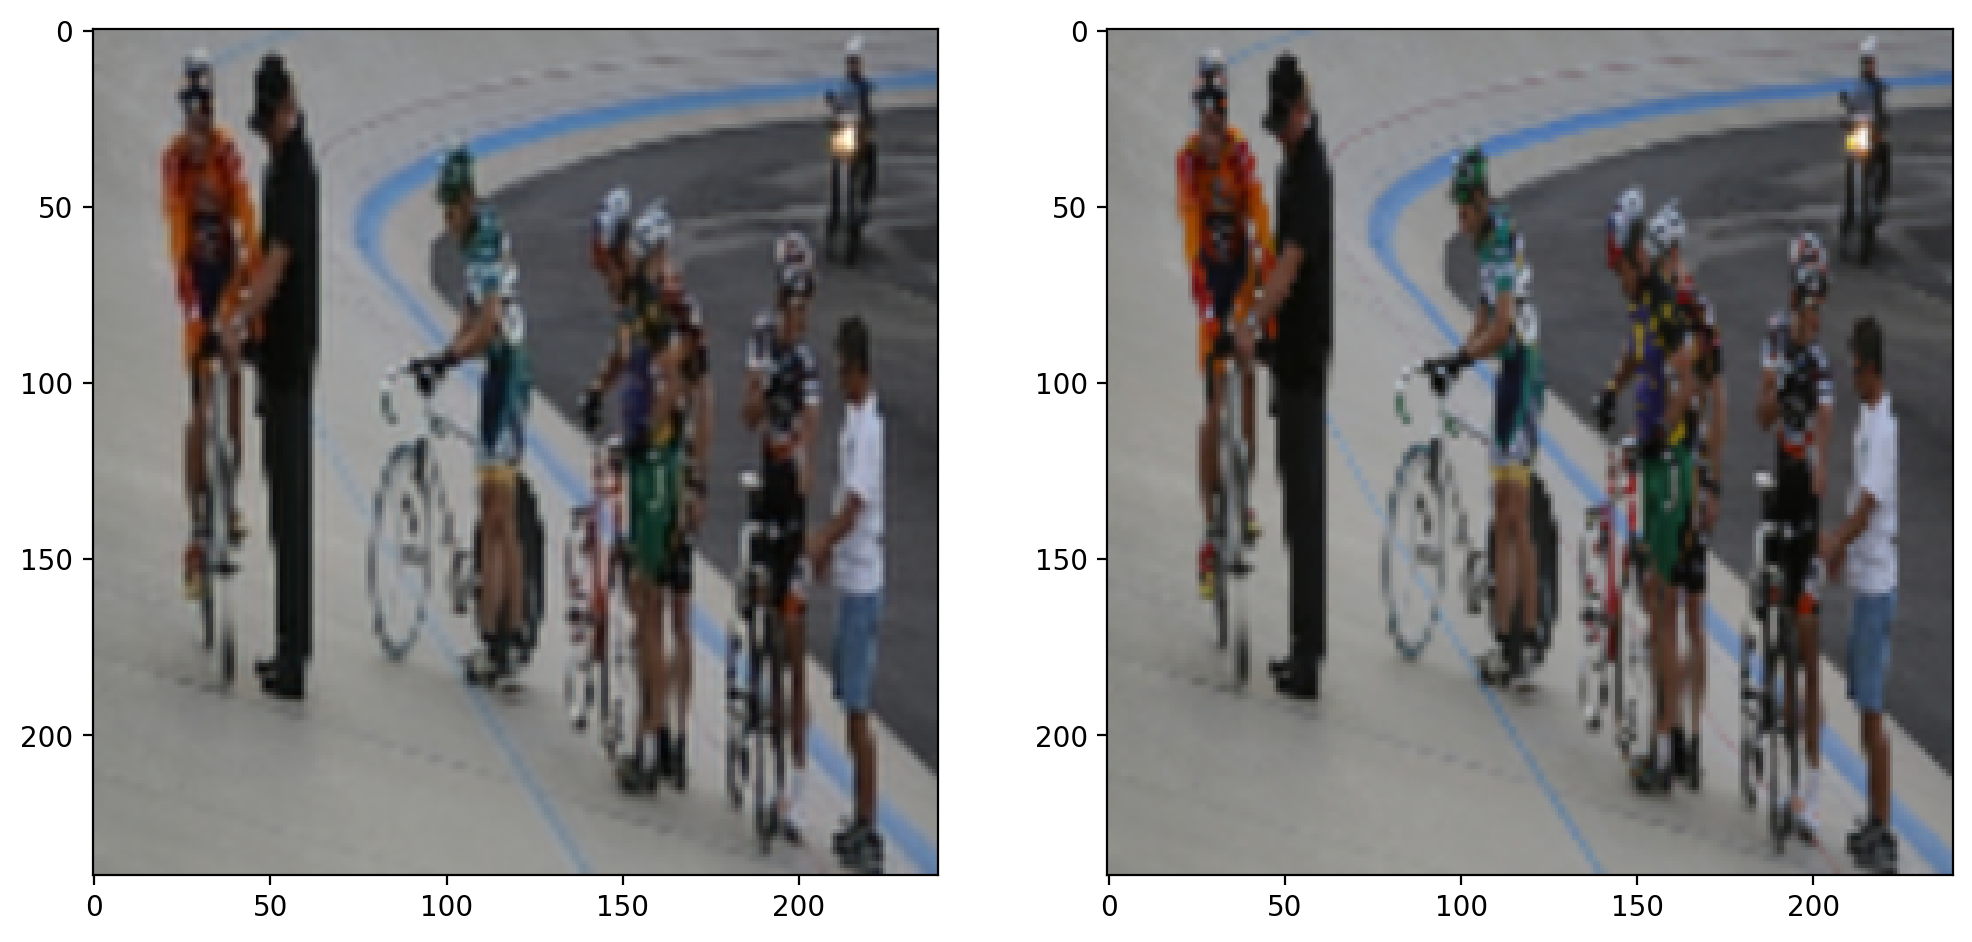

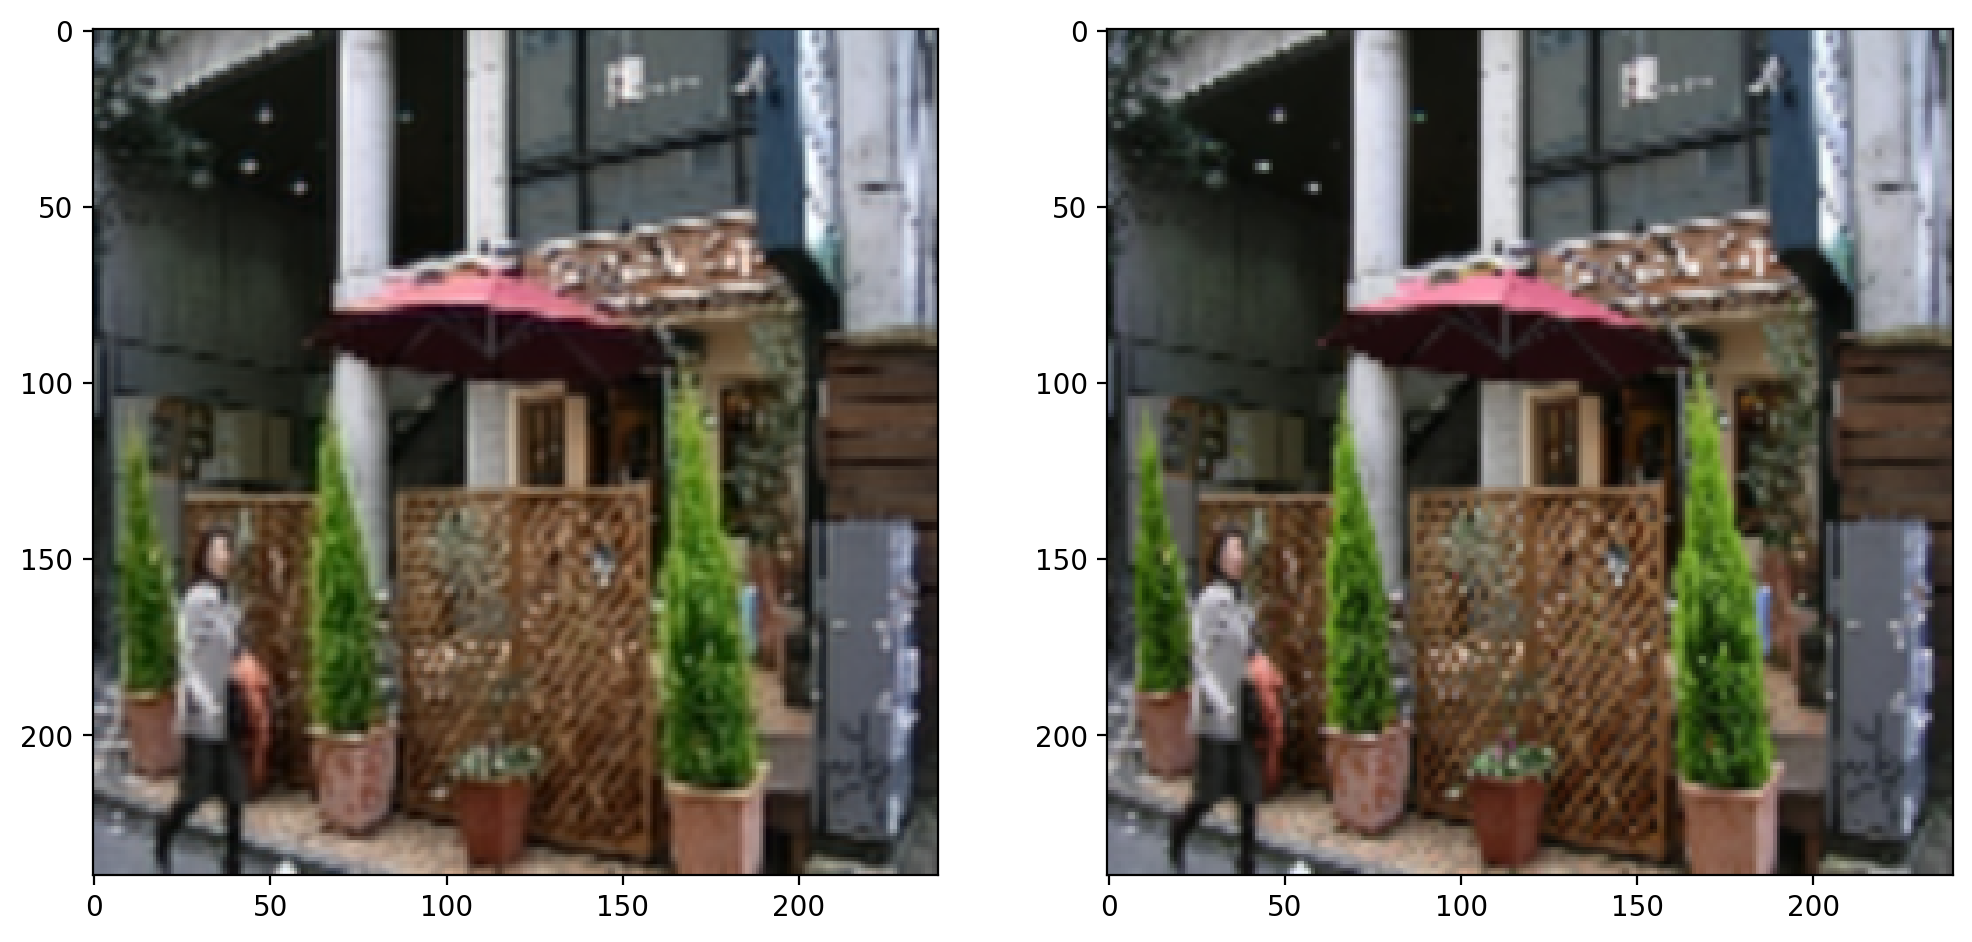

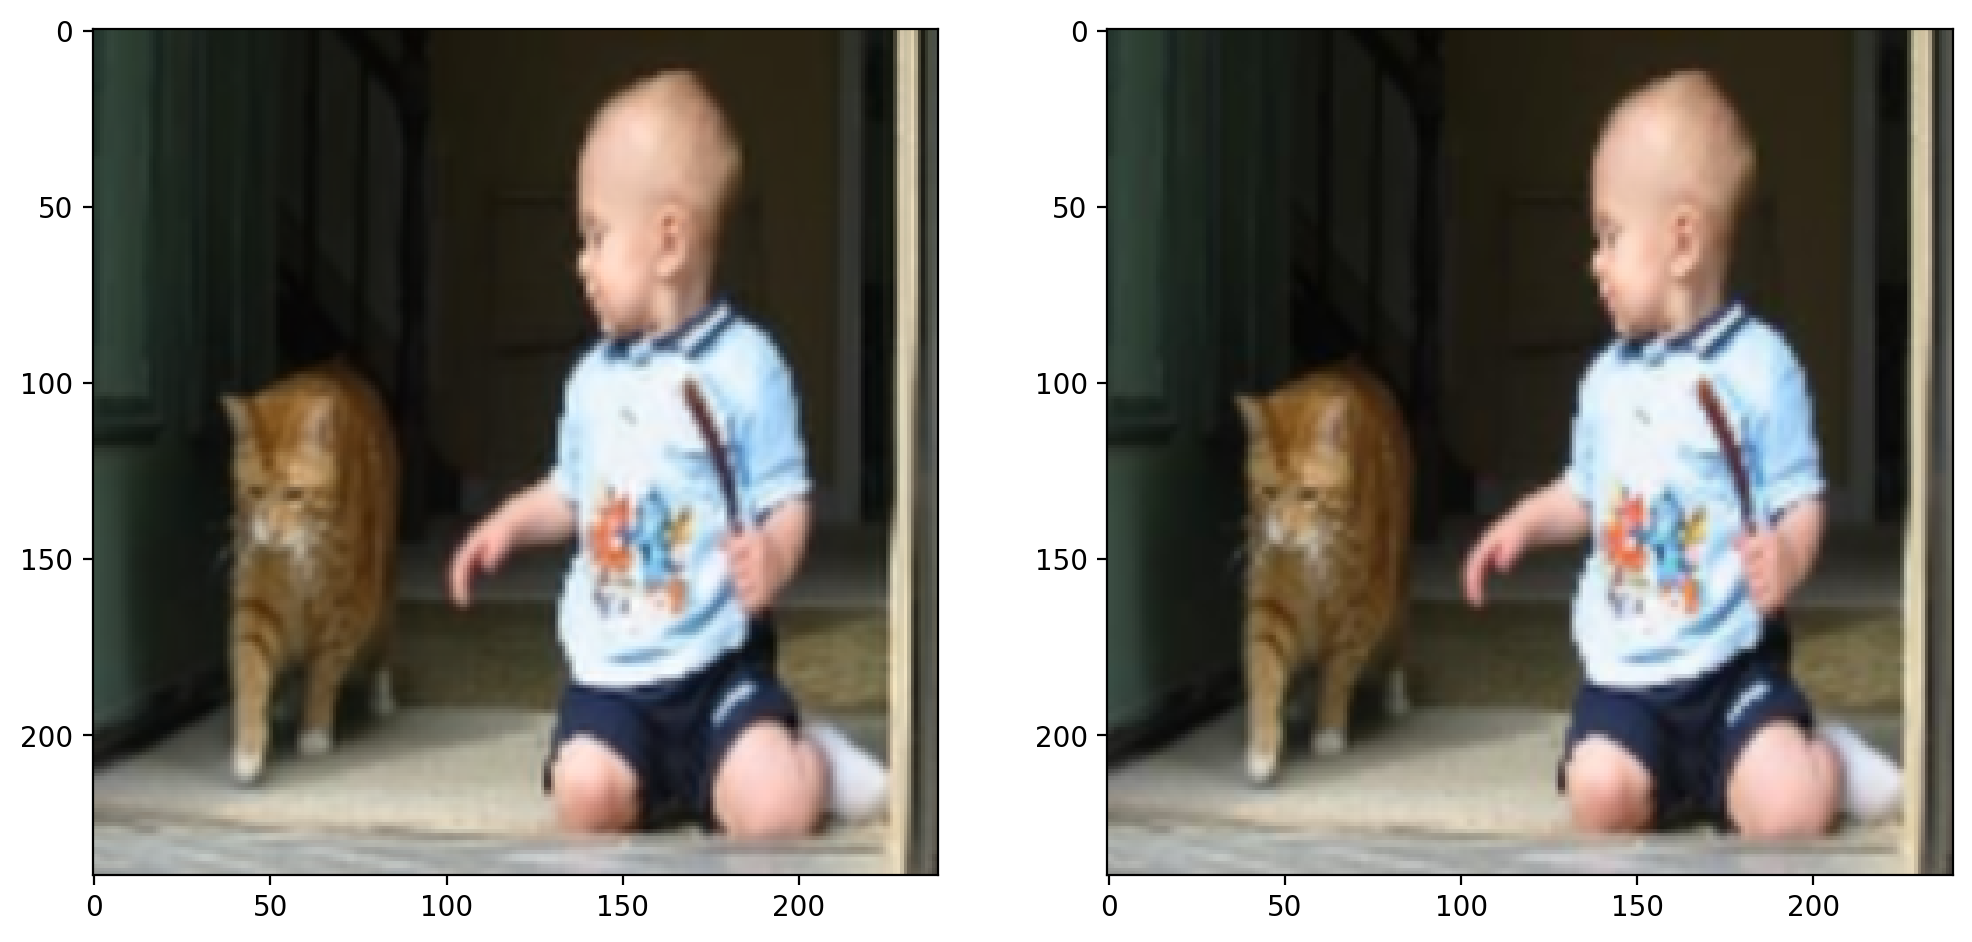

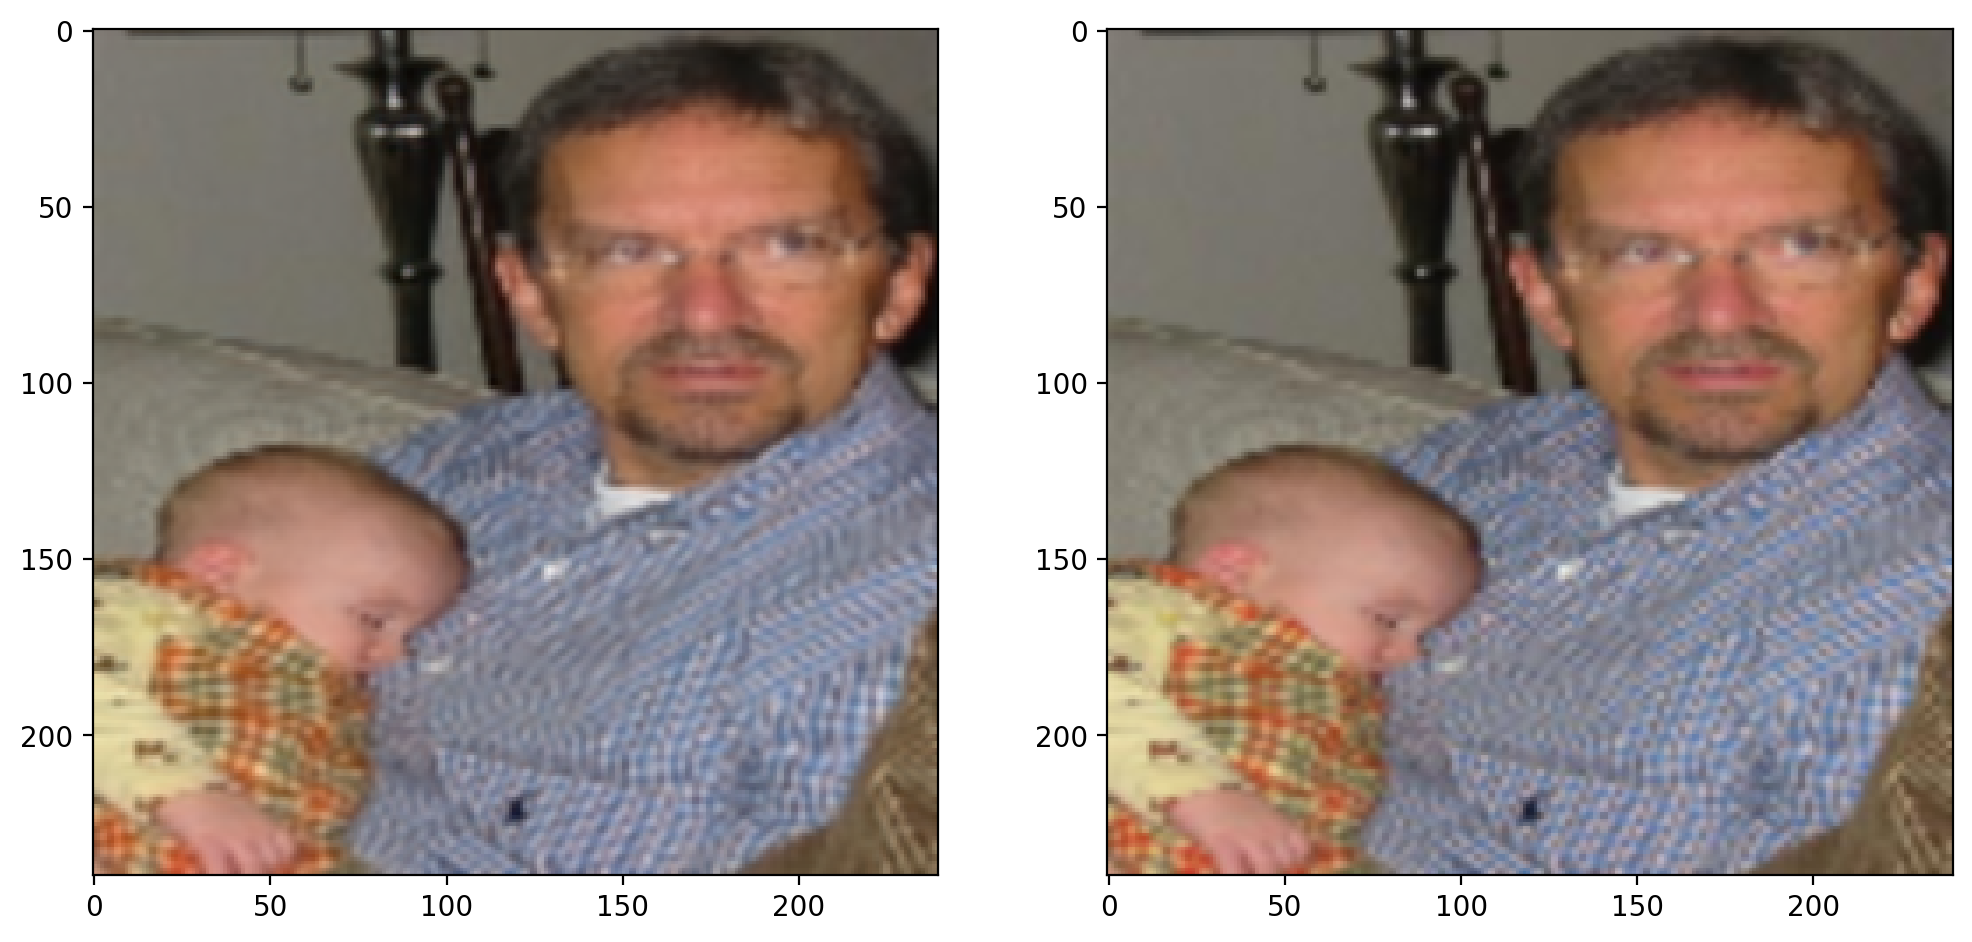

In [ ]:
for i in range(9):

  fig = plt.figure(figsize=(12,12),dpi=200)
  ax = fig.add_subplot(1, 2, 1)
  ax.imshow(np.transpose(np.hstack(results1[i]),(1, 2, 0)))
  ax2 = fig.add_subplot(1, 2, 2)
  a=image_datasets["val"][i][0]
  ax2.imshow(np.transpose((a),(1, 2, 0)))

We can see it is less blurry now, we got some improvement.

*************************

# Training the model with the addition of perceptual loss to the regular MSE-loss

We will train the model with the addition of perceptual loss to the regular MSE-loss
By feeding a pre-trained vgg-16 network with the network output (240x240x3), you get
the image activations. Usually the activations that are taking into account for the
perceptual loss are: relu1_2, relu2_2, relu3_3, relu4_3. This should be done also for the
ground-truth image.
Then, the perceptual loss is defined as the MSE-loss between the activations of the
output and the ground-truth.

A visualization of the process is described below.
Perceptual loss:
MSE(vgg(output)_relu1_2,vgg(ground-truth)_relu2_2) +...+
MSE(vgg(output)_relu4_3,vgg(ground-truth)_relu4_3)

In [ ]:
VGG = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
print(summary(VGG, (3, 240, 240)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 240]           1,792
              ReLU-2         [-1, 64, 240, 240]               0
            Conv2d-3         [-1, 64, 240, 240]          36,928
              ReLU-4         [-1, 64, 240, 240]               0
         MaxPool2d-5         [-1, 64, 120, 120]               0
            Conv2d-6        [-1, 128, 120, 120]          73,856
              ReLU-7        [-1, 128, 120, 120]               0
            Conv2d-8        [-1, 128, 120, 120]         147,584
              ReLU-9        [-1, 128, 120, 120]               0
        MaxPool2d-10          [-1, 128, 60, 60]               0
           Conv2d-11          [-1, 256, 60, 60]         295,168
             ReLU-12          [-1, 256, 60, 60]               0
           Conv2d-13          [-1, 256, 60, 60]         590,080
             ReLU-14          [-1, 256,

In [ ]:
features = {}
def get_layers(name):
    def hook(model, input, output):
        features[name] = output#.detach()
    return hook

In [ ]:
VGG.features[3].register_forward_hook(get_layers('relu1_2'))
VGG.features[8].register_forward_hook(get_layers('relu2_2'))
VGG.features[15].register_forward_hook(get_layers('relu3_3'))
VGG.features[22].register_forward_hook(get_layers('relu4_3'))

In [ ]:
def extract_features_from_VGG(VGG, img):
    global features
    #with torch.no_grad():
    output = VGG(img)
    return dict(features)

In [ ]:
def train_model1(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    # since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_list = [] #For printing the plot of the loss and accuracy
    train_acc_list = []

    val_loss_list = []
    val_acc_list = []
    results=[]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            

            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs) 
                    HQ_features = extract_features_from_VGG(VGG, labels)
                    output_features = extract_features_from_VGG(VGG, outputs)
                    loss1 = criterion(HQ_features['relu1_2'], output_features['relu1_2'])
                    loss2 = criterion(HQ_features['relu2_2'], output_features['relu2_2'])
                    loss3 = criterion(HQ_features['relu3_3'], output_features['relu3_3'])
                    loss4 = criterion(HQ_features['relu4_3'], output_features['relu4_3'])
                    loss = loss1+loss2+loss3+loss4

                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    # outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    if (phase == 'val') and (epoch==num_epochs-1):
                      results.append(outputs)
                    _, preds = torch.max(outputs, 1) # 
                    # loss = criterion(outputs, labels)
                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                # running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = 5 / dataset_sizes[phase]

            if phase == 'train':
              train_loss_list.append(epoch_loss)
              train_acc_list.append(epoch_acc)
            else:
              val_loss_list.append(epoch_loss)
              val_acc_list.append(epoch_acc)


            # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            print(f'{phase} Loss: {epoch_loss:.4f} ')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    


    # time_elapsed = time.time() - since
    # print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    # print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    
    return model,results, train_loss_list, val_loss_list, train_acc_list, val_acc_list

In [ ]:
model=SRCNN().to(device)

# criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)
	# defining the loss function
criterion = torch.nn.MSELoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
print(summary(model, (3, 240, 240)))
num_epochs = 10

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 240]          15,616
            Conv2d-2         [-1, 32, 240, 240]           2,080
            Conv2d-3          [-1, 3, 240, 240]           2,403
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.66
Forward/backward pass size (MB): 43.51
Params size (MB): 0.08
Estimated Total Size (MB): 44.24
----------------------------------------------------------------
None


In [ ]:
trained_model,results2, train_loss2, val_loss2, train_acc2, val_acc2 = train_model1(model, 
                    dataloaders,
                       criterion, 
                       optimizer, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 4.3077 
val Loss: 3.1246 

Epoch 1/9
----------
train Loss: 2.9516 
val Loss: 2.8115 

Epoch 2/9
----------
train Loss: 2.8581 
val Loss: 2.7777 

Epoch 3/9
----------
train Loss: 2.7931 
val Loss: 2.7744 

Epoch 4/9
----------
train Loss: 2.7725 
val Loss: 2.7199 

Epoch 5/9
----------
train Loss: 2.7627 
val Loss: 2.6586 

Epoch 6/9
----------
train Loss: 2.7191 
val Loss: 2.6569 

Epoch 7/9
----------
train Loss: 2.6778 
val Loss: 2.6321 

Epoch 8/9
----------
train Loss: 2.6723 
val Loss: 2.6289 

Epoch 9/9
----------
train Loss: 2.6659 
val Loss: 2.6207 



Text(0, 0.5, 'Loss')

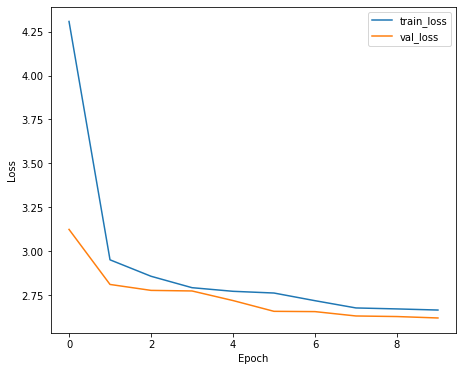

In [ ]:
fig = plt.figure(figsize = (16,6))

plt.subplot(1,2,2)
plt.plot(train_loss2)
plt.plot(val_loss2)
plt.legend(['train_loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

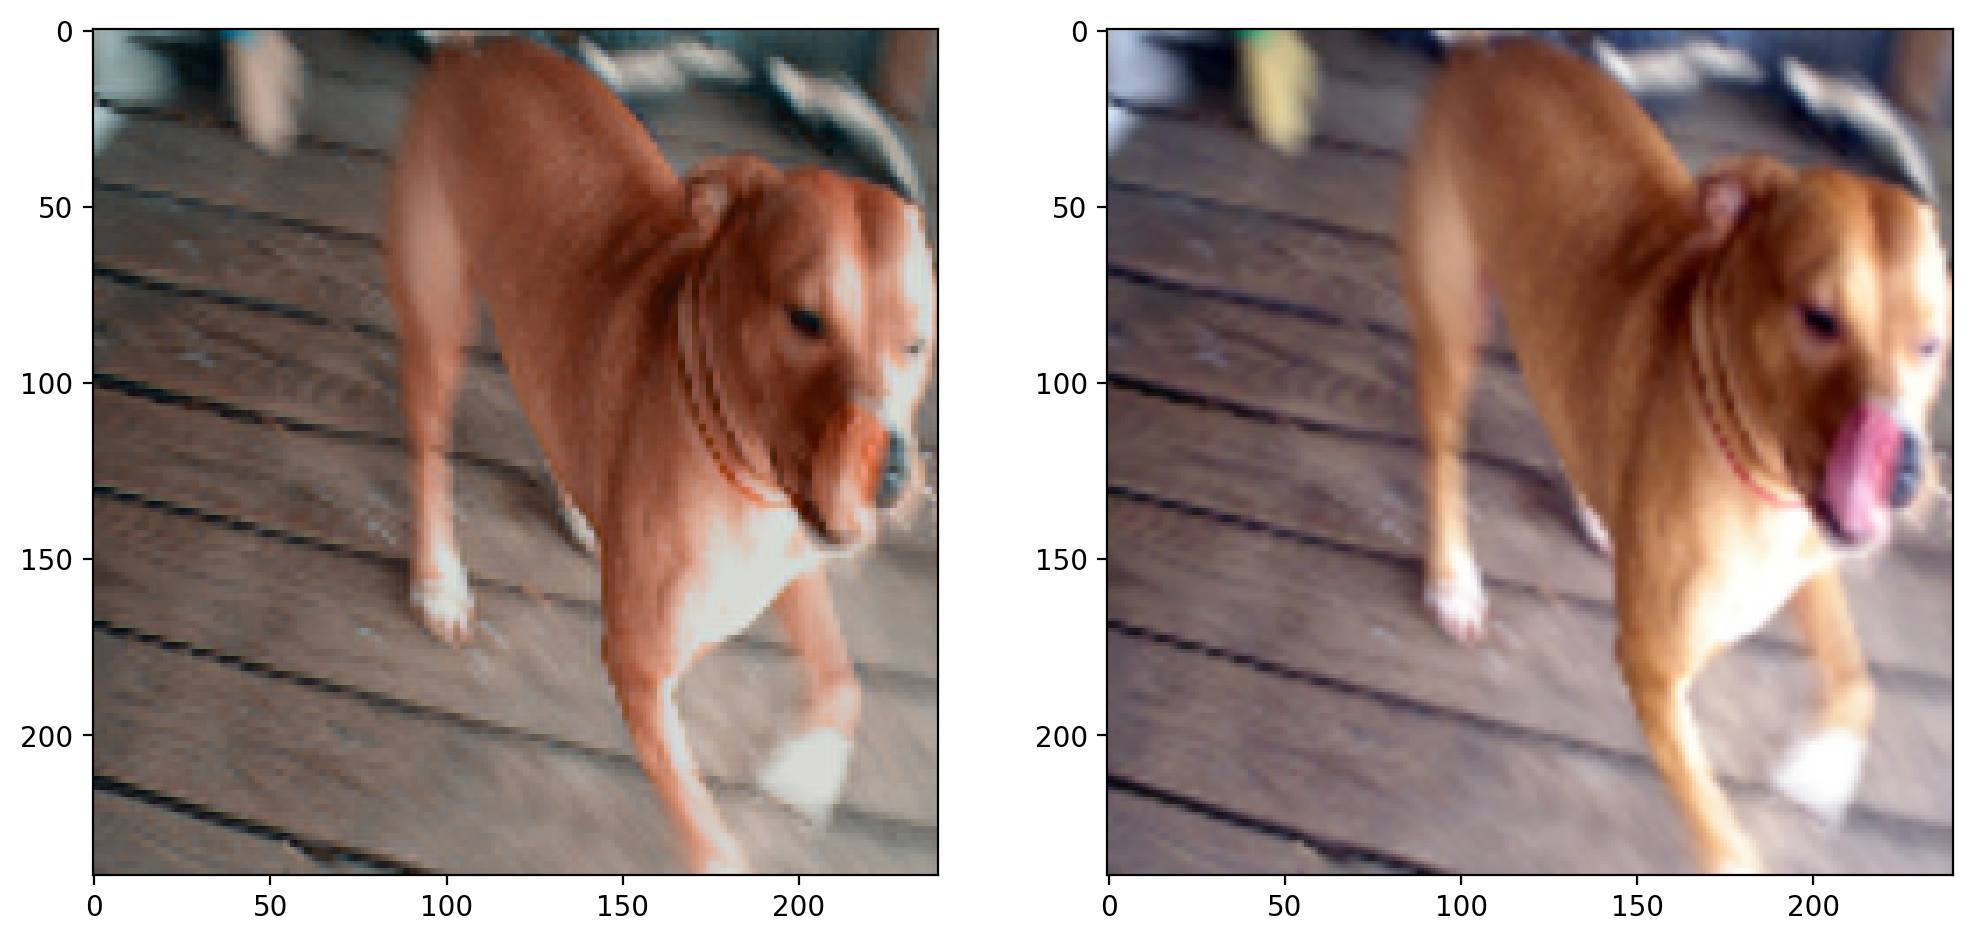

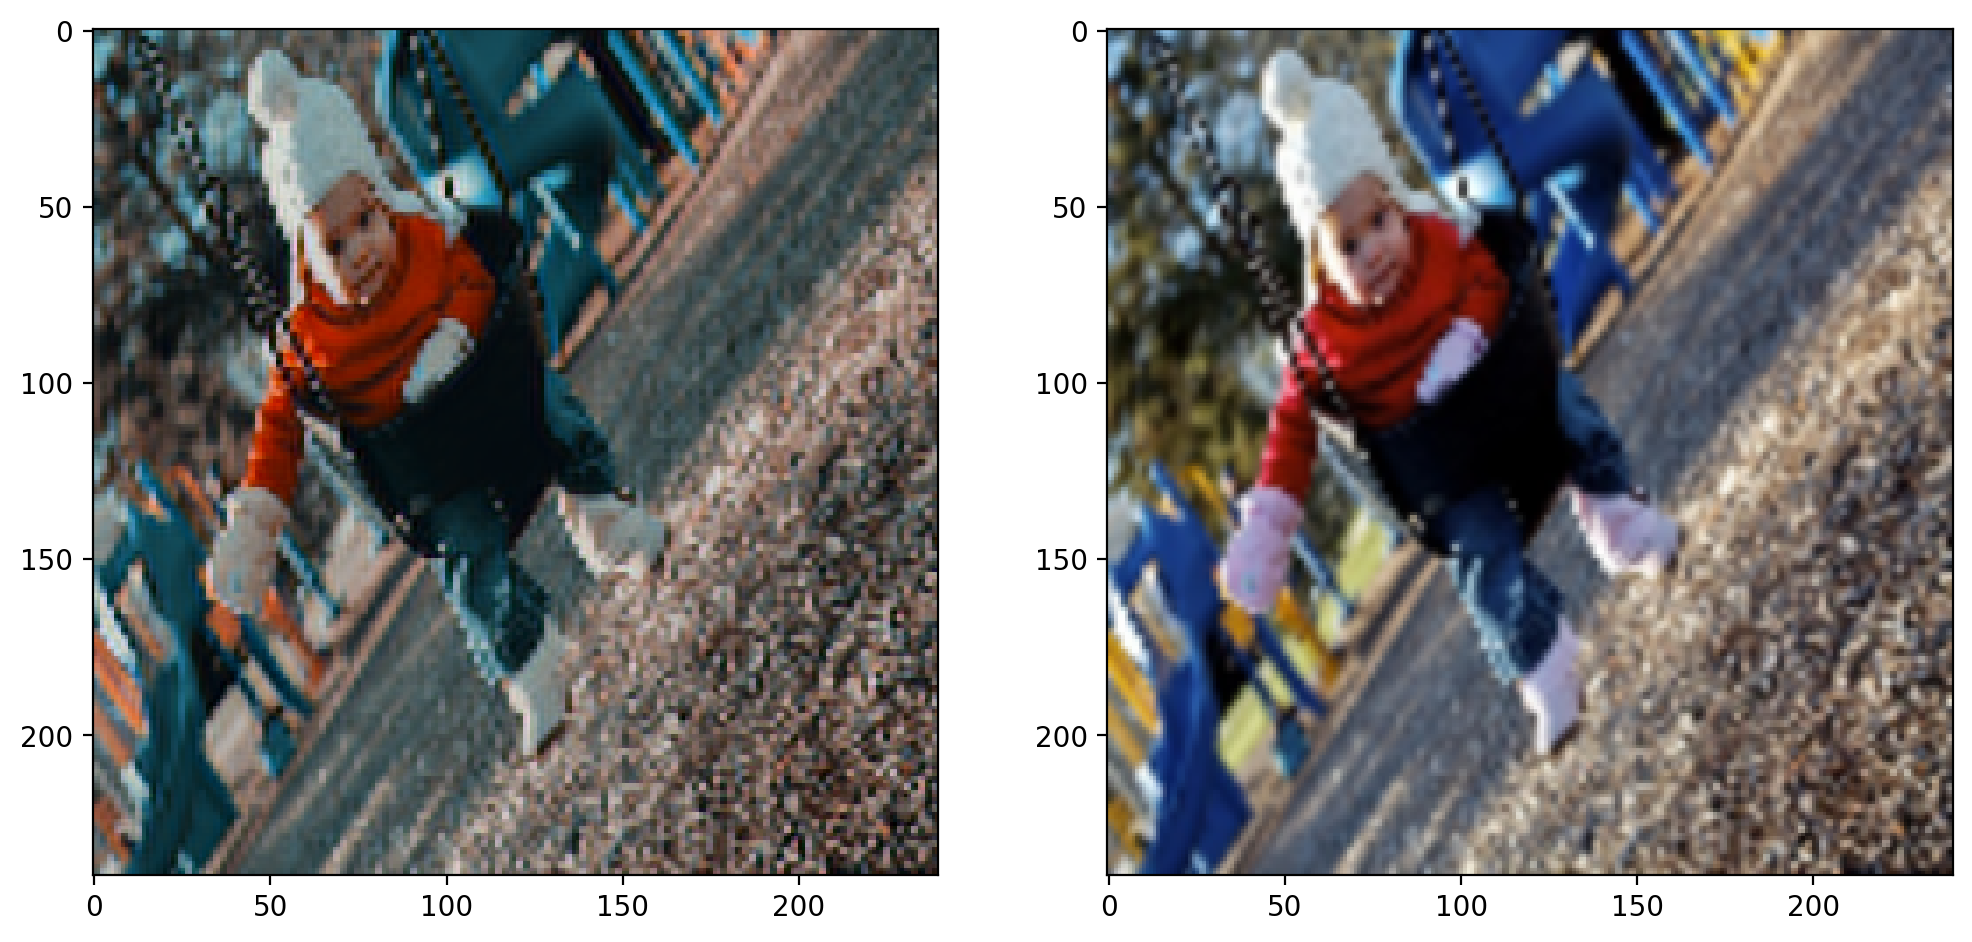

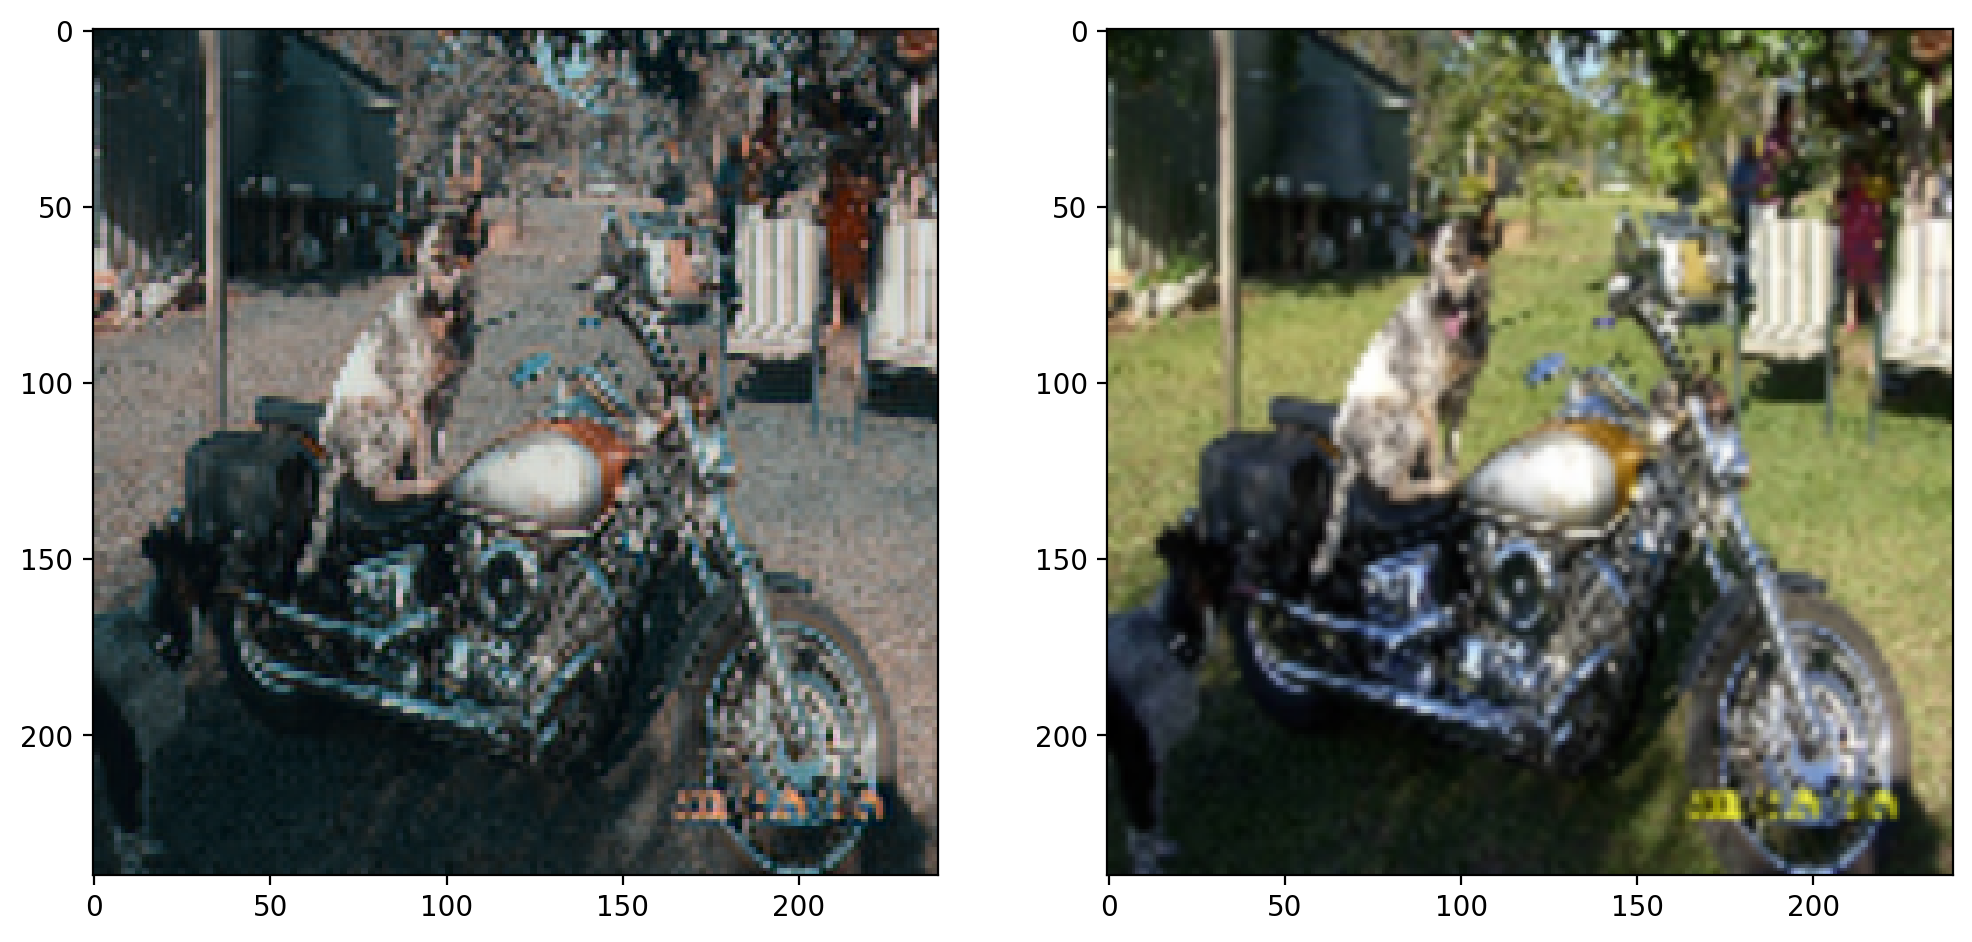

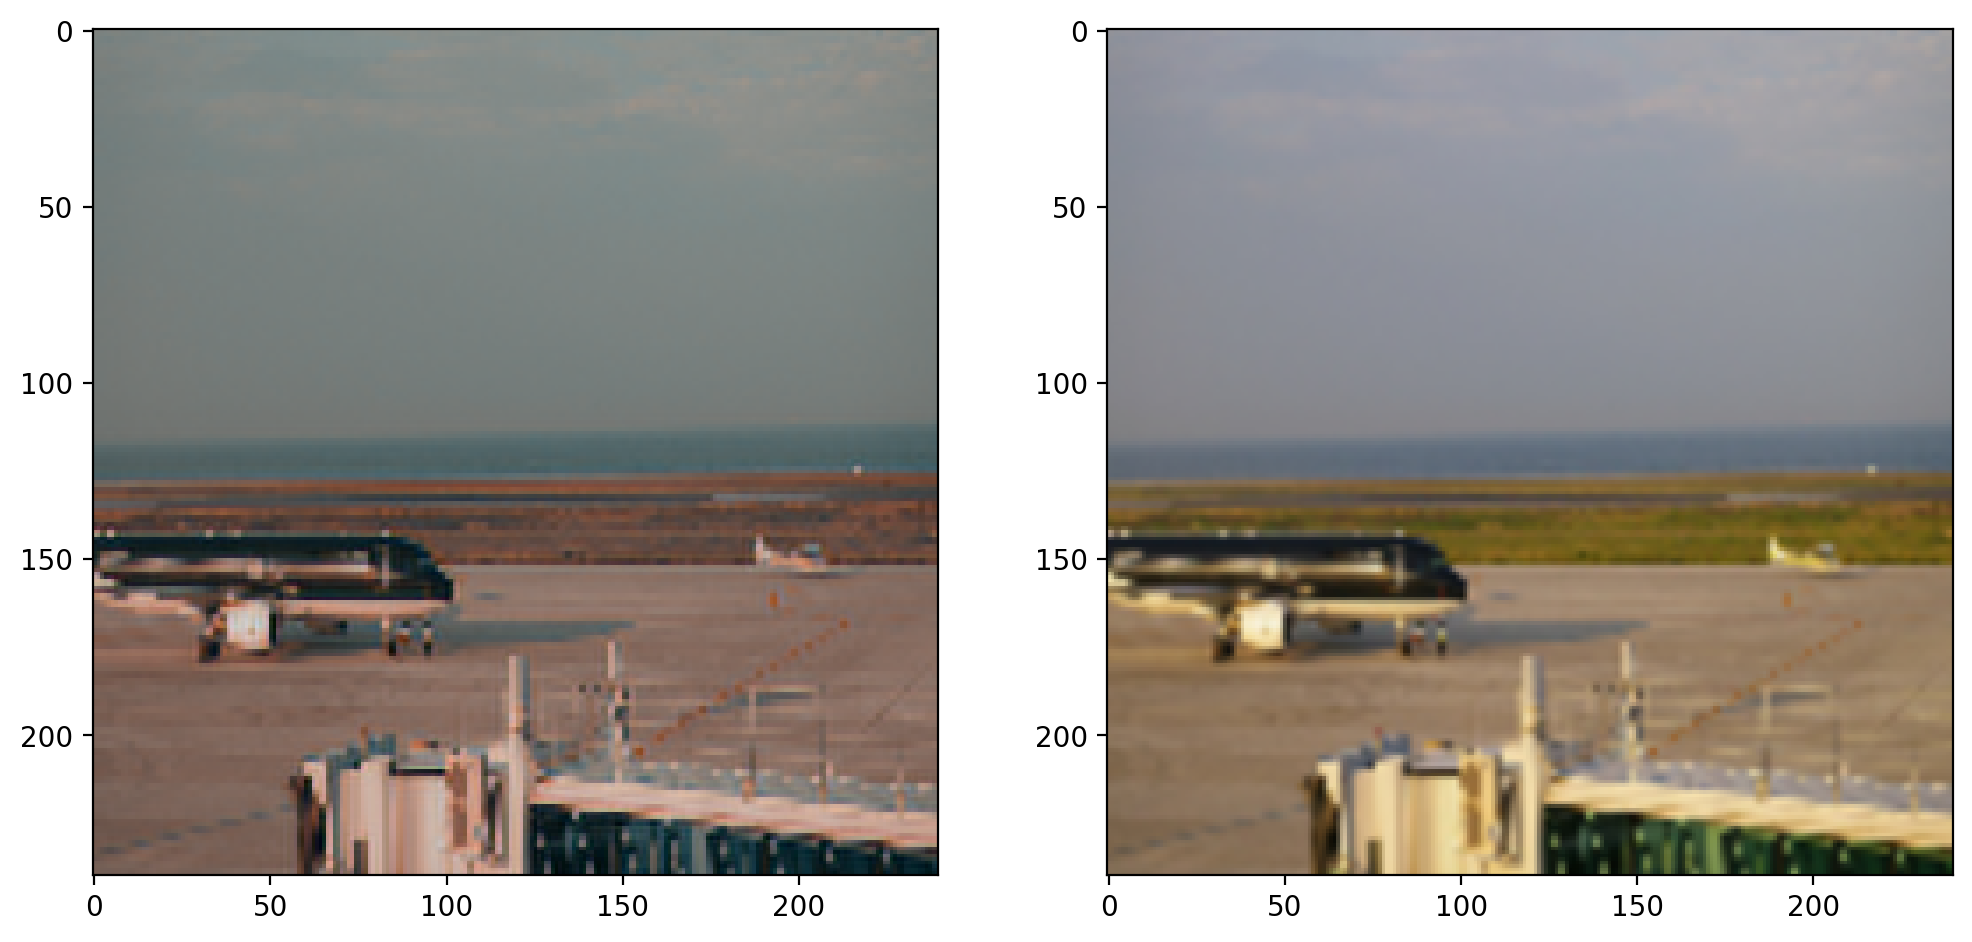

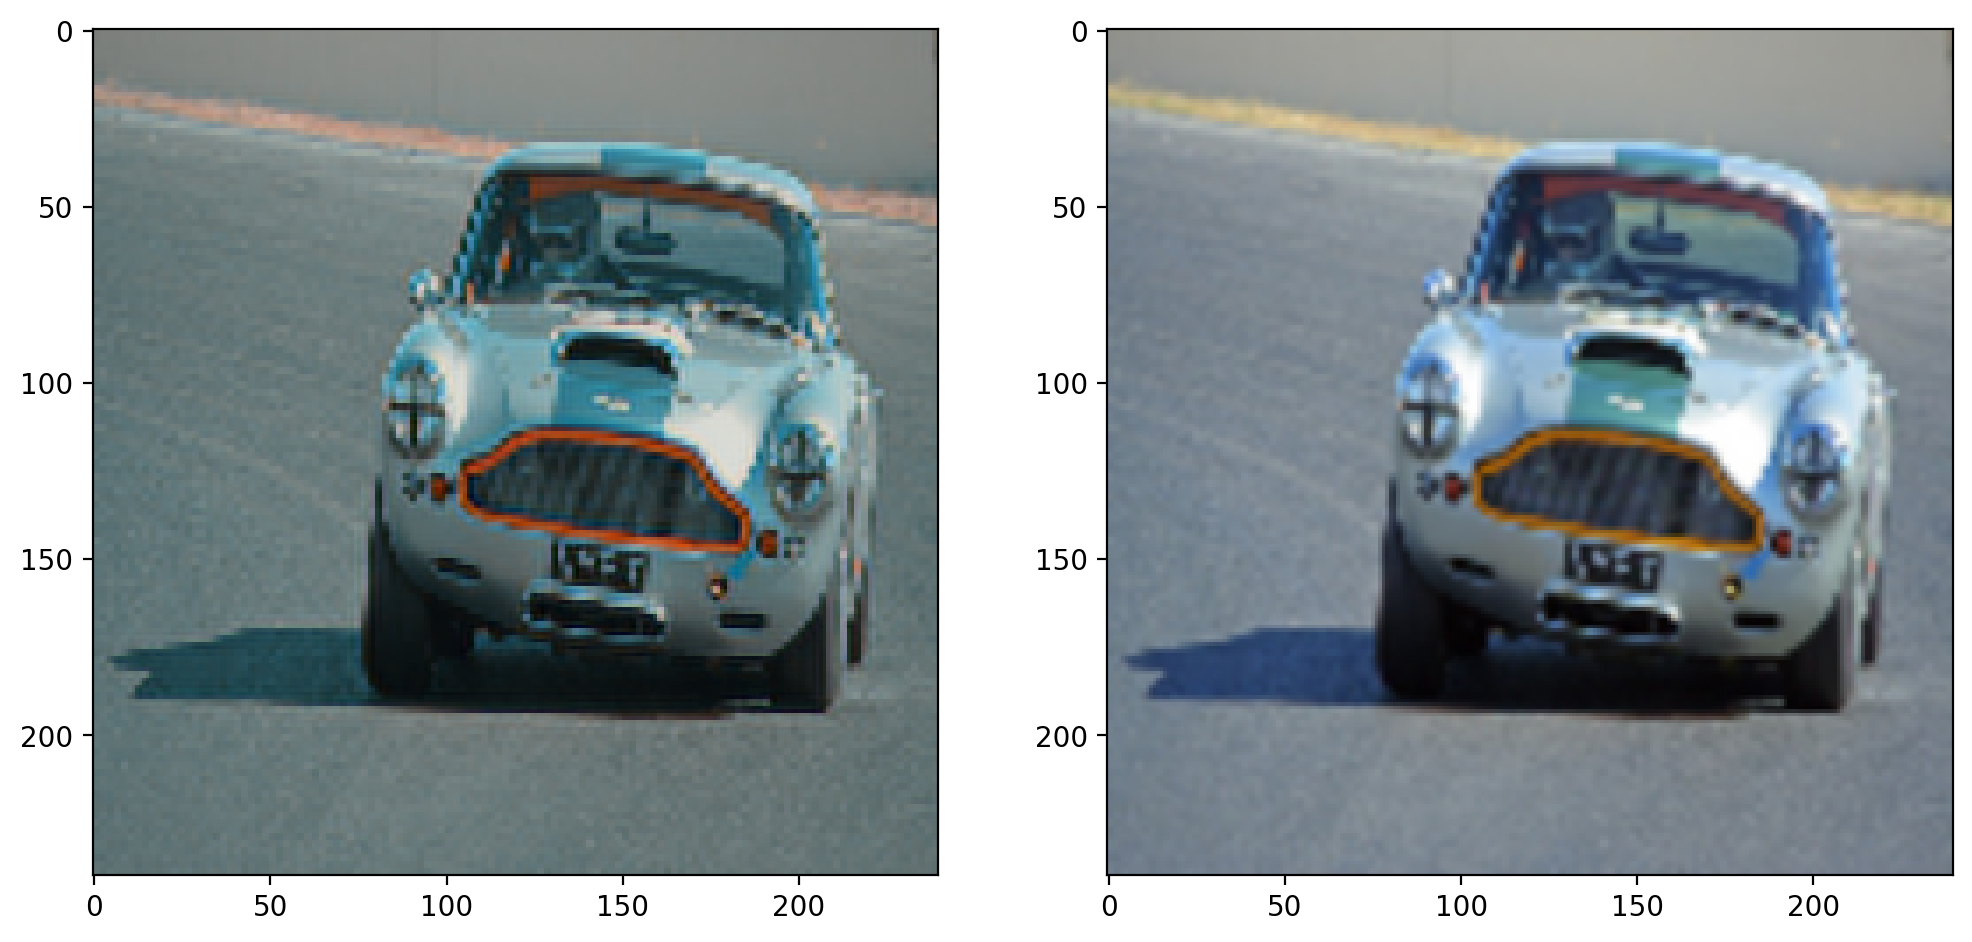

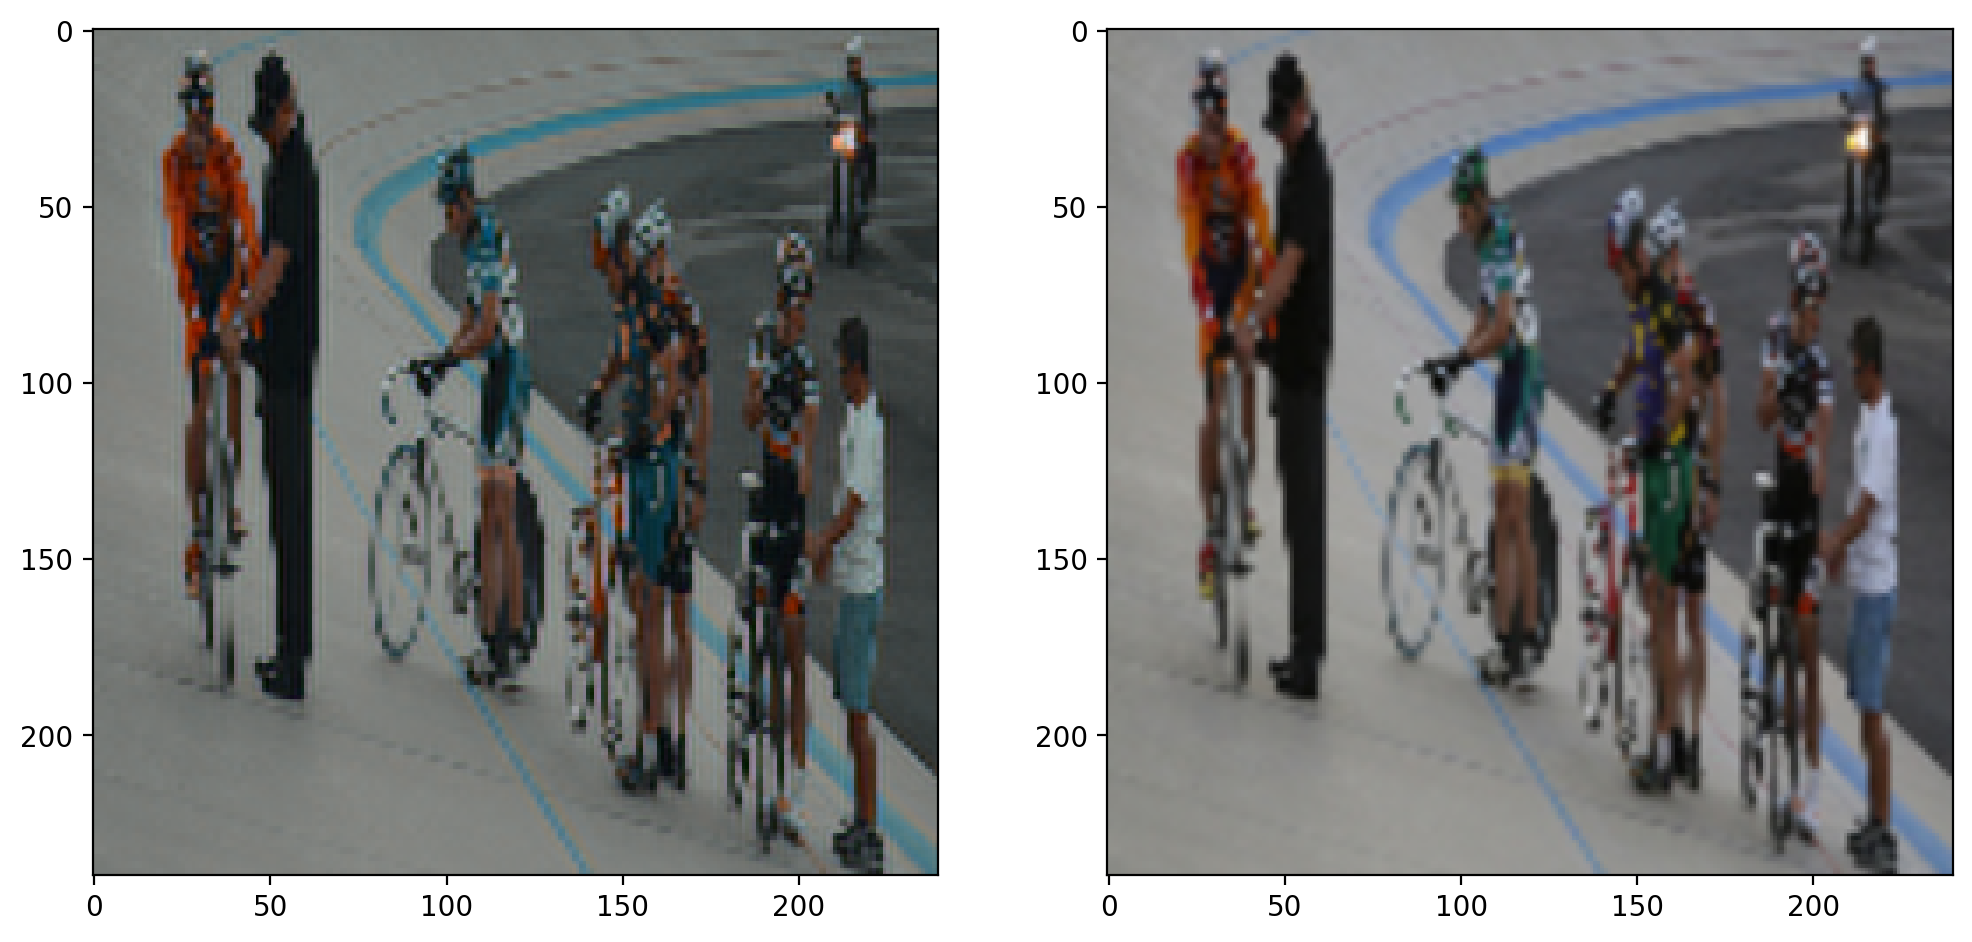

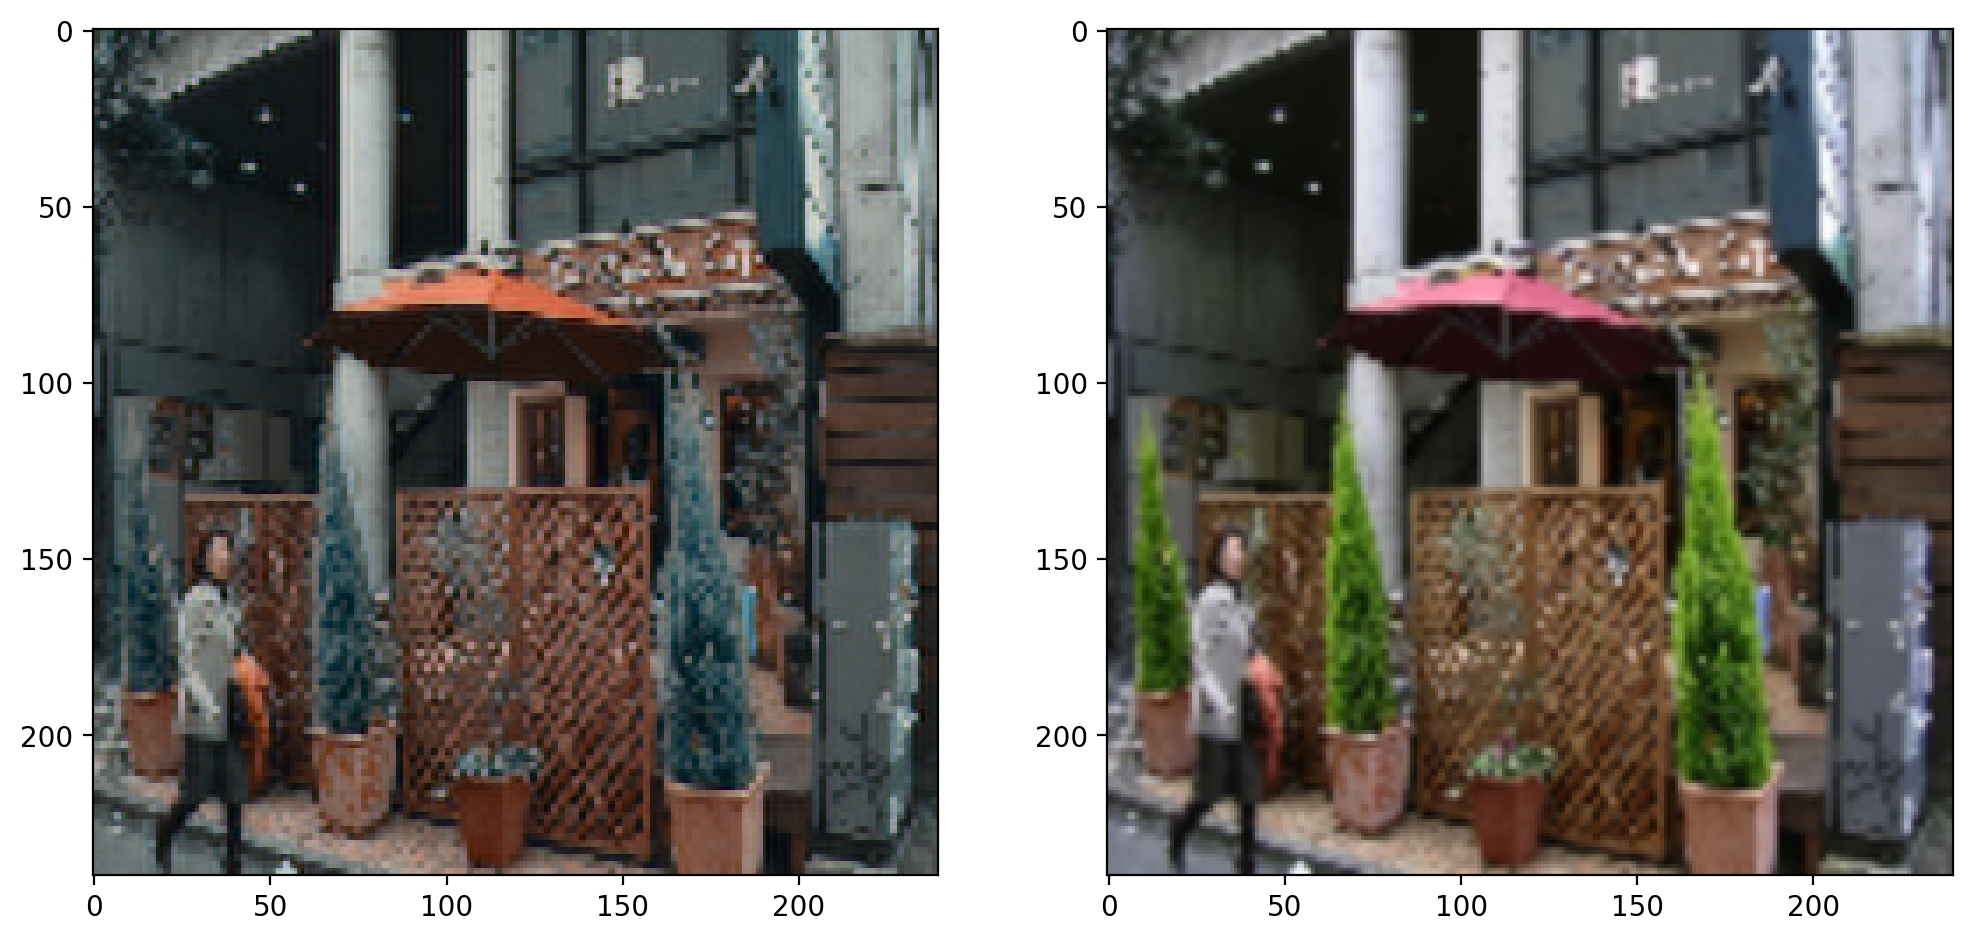

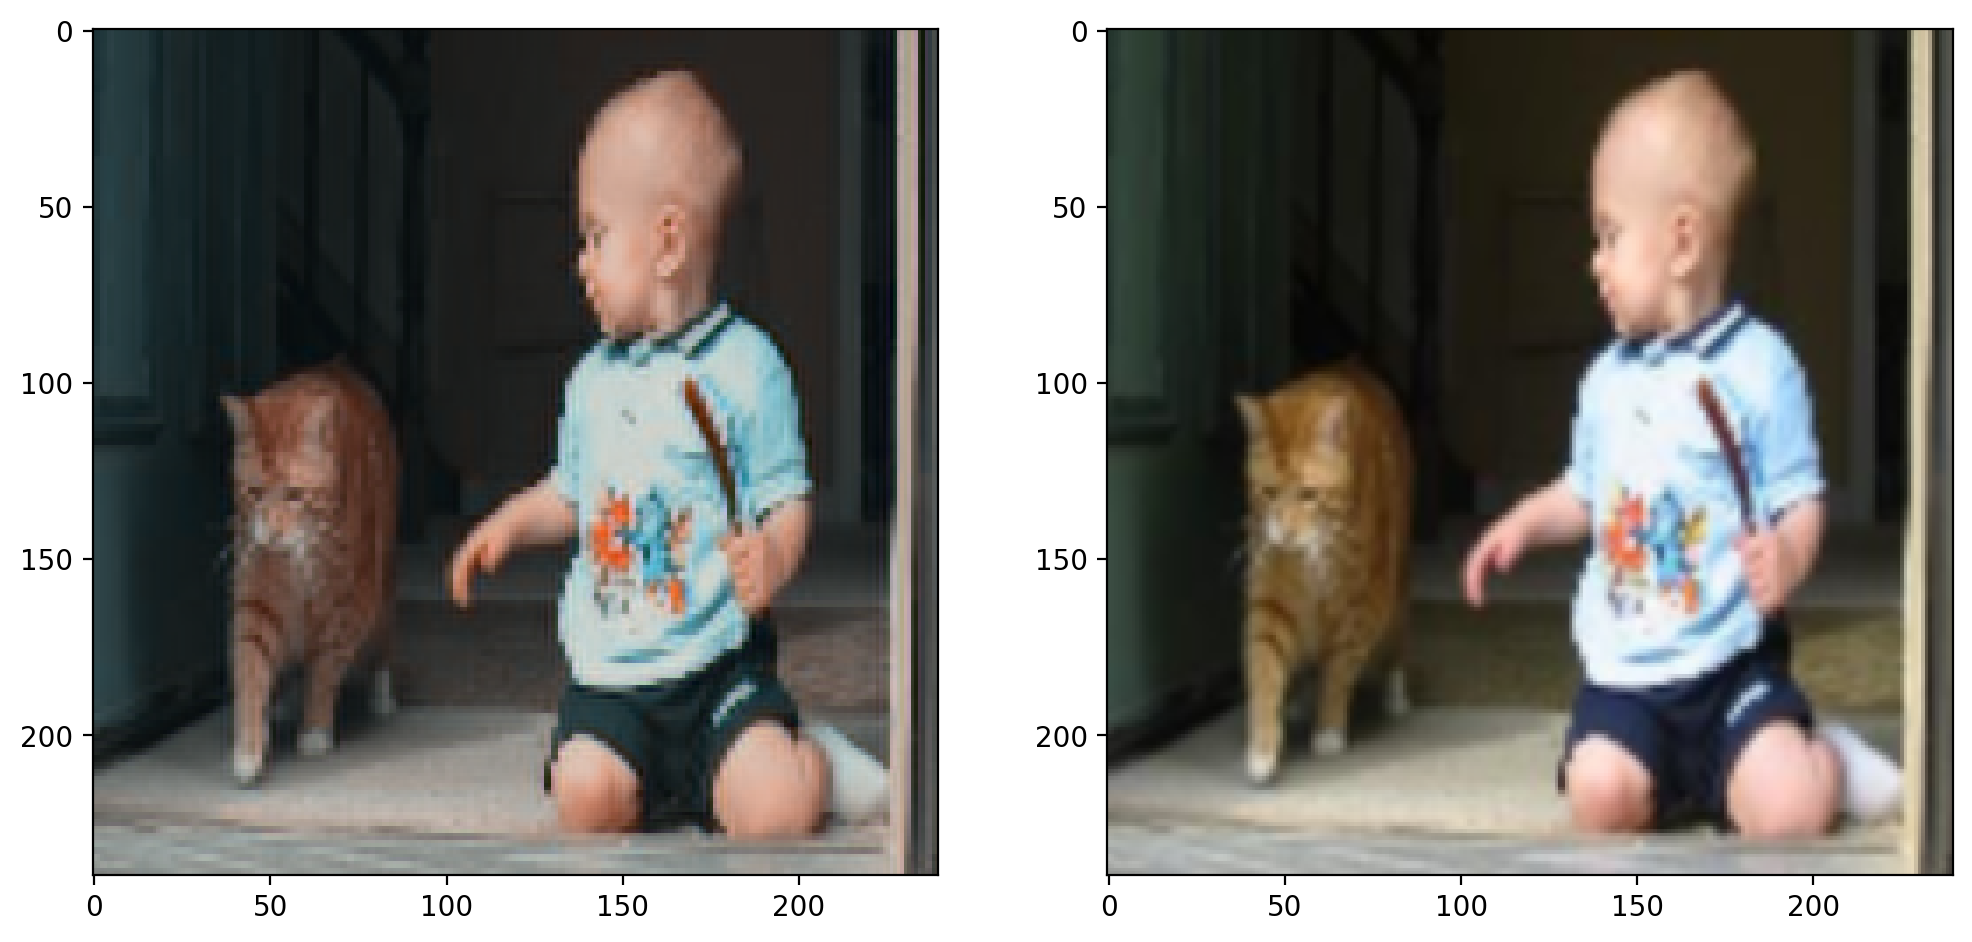

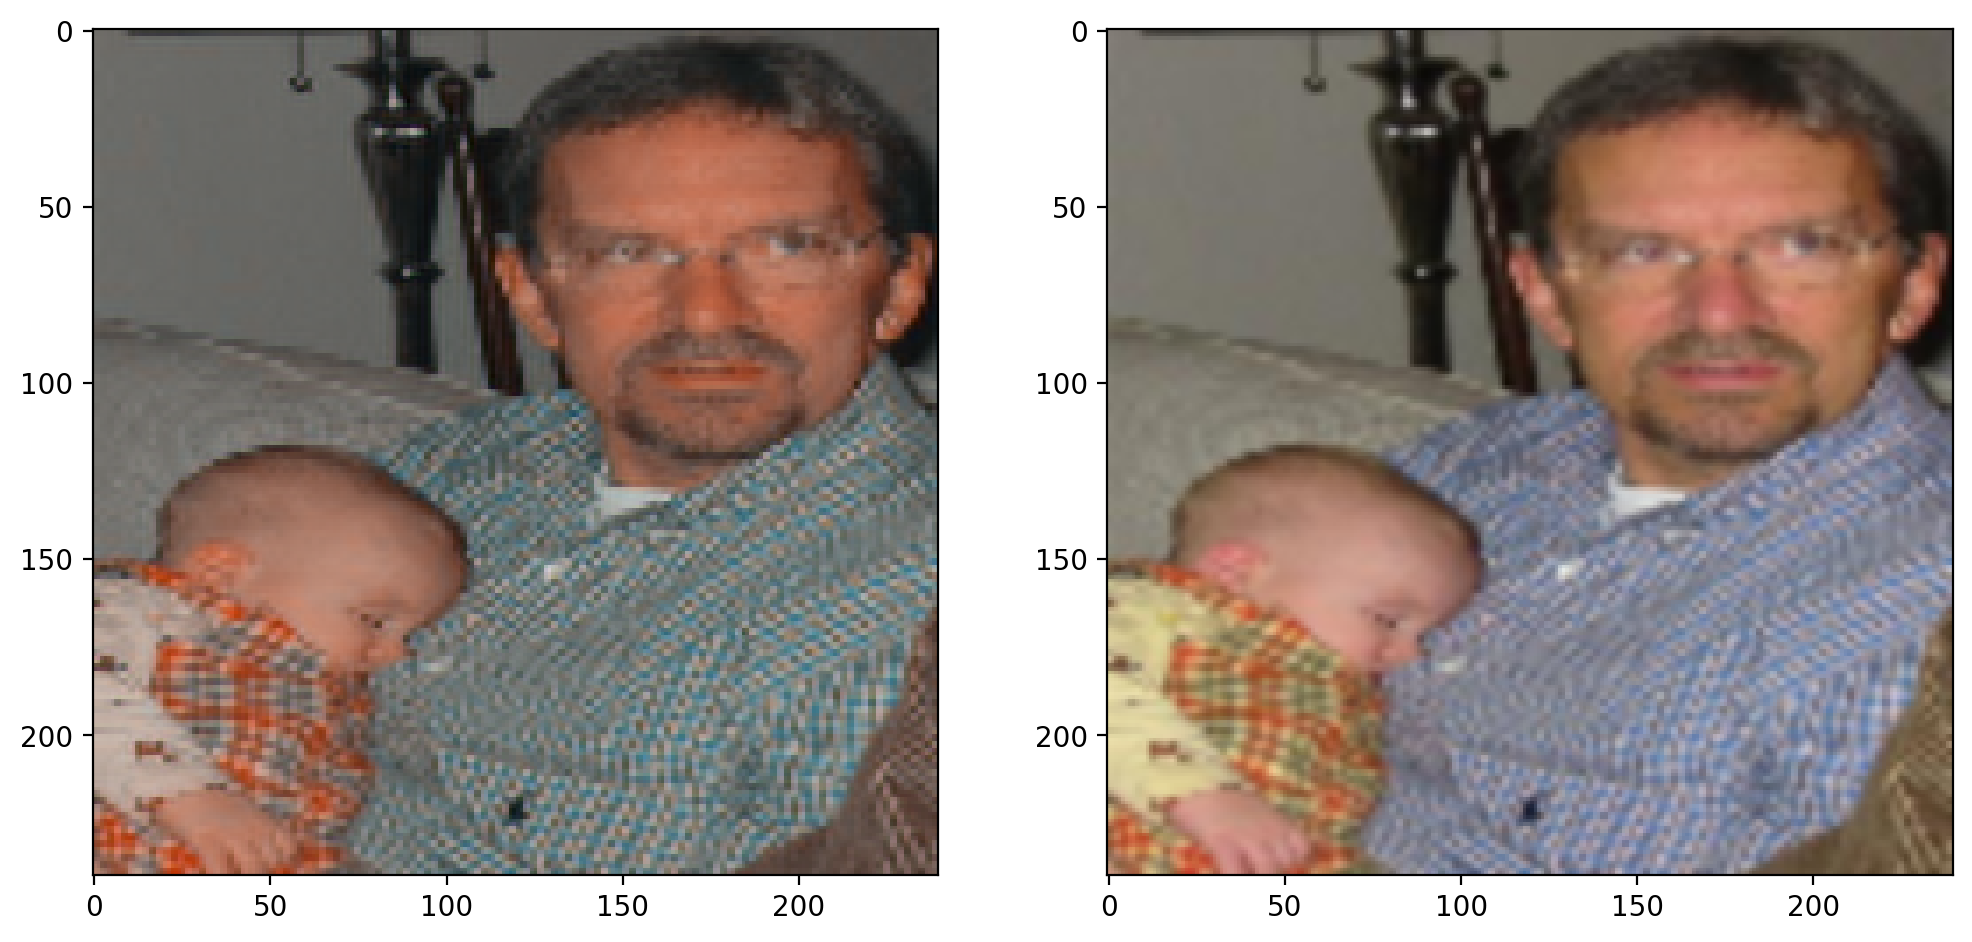

In [ ]:
for i in range(9):

  fig = plt.figure(figsize=(12,12),dpi=200)
  ax = fig.add_subplot(1, 2, 1)
  ax.imshow(np.transpose(np.hstack(results2[i]),(1, 2, 0)))
  ax2 = fig.add_subplot(1, 2, 2)
  a=image_datasets["val"][i][0]
  ax2.imshow(np.transpose((a),(1, 2, 0)))

# Summary

We can see that the ruselts of perceptual los in much better and less bluryy.

Even though the colors were changed a little bit.